<h1 style="text-align: center; vertical-align: middle;">Differentiable beam dynamics simulation tutorial</h1>
<h2 style="text-align: center; vertical-align: middle;">using Cheetah</h2>

<h3 style="text-align: center; vertical-align: middle;">5th ICFA Beam Dynamics Mini-Workshop on Machine Learning for Particle Accelerators</h3>

<p style="text-align: center; vertical-align: middle;">
Jan Kaiser, Chenran Xu, Andrea Santamaria Garcia, and Juan Pablo Gonzalez-Aguilera
</p>


<h2 style="color: #b51f2a">Getting started</h2>

- You will need **Python 3.12 or higher** to run this code &#x2757;
- You will require about **1 GB of free disk space** &#x2757;
- Make sure you have Git installed in your terminal &#x2757;

Start by cloning locally the repository of the tutorial by running this command in your terminal:

```bash
git clone https://github.com/MALAPA-Collab/cheetah-tutorial-2025
```


<h2 style="color: #b51f2a">Installing virtual environment</h2>

### Using Conda

- If you don't have conda installed already, you can install the `miniconda` as [described here](https://docs.conda.io/projects/miniconda/en/latest/miniconda-install.html).
- We recommend installing `miniconda` the day beforehand to avoid network overload during the tutorial &#x2757; &#x2757;

Once `miniconda` is installed run this command in your terminal:

```bash
conda env create -f environment.yaml
```

This should create a virtual environment named `malapa-cheetah-tutorial-2025` and install the necessary packages inside.

Afterwards, activate the environment using

```bash
conda activate malapa-cheetah-tutorial-2025
```


<h2 style="color: #b51f2a">Installing virtual environment</h2>

### Using venv

_If you don't have conda installed:_

Alternatively, you can create the virtual env with

```bash
python3 -m venv malapa-cheetah-tutorial-2025
```

and activate the env with `$ source <venv>/bin/activate` (bash) or `C:> <venv>/Scripts/activate.bat` (Windows)

Then, install the packages with `pip` within the activated environment

```bash
python -m pip install -r requirements.txt
```

Afterwards, you should be able to run the provided scripts.


<h2 style="color: #b51f2a">Check your installation</h2>
If you set up your virtual environment correctly and is activated you should be able to run the next cell without any errors:


In [1]:
import pickle
from copy import deepcopy
from typing import Iterator, Literal

import cheetah
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import xopt
from gpsr.beams import NNParticleBeamGenerator
from gpsr.datasets import SixDReconstructionDataset
from gpsr.modeling import GPSR, GPSR6DLattice
from gpsr.train import LitGPSR
from gpytorch.constraints.constraints import Positive
from gpytorch.means import Mean
from gpytorch.priors import SmoothedBoxPrior
from sklearn.utils import shuffle
from tqdm import trange
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

from src.utils import *

torch.manual_seed(42)
plt.style.use(["science", "ieee", "no-latex"])

<h2 style="color: #b51f2a">In this tutorial</h2>

<h3 style="color: #b51f2a">Introduction</h3>

- What are differentiable simulations? - ASG
- What is automatic differentiation? - ASG
- How do we use the gradient? - ASG
- What is Cheetah? - JK

<h3 style="color: #b51f2a">Programming examples</h3>

- **Example 1**: getting started with Cheetah (10 min) - JK
- **Example 2**: gradient-based system identification (10 min) - CX
- **Example 3**: Bayesian optimisation informed prior (10 min) - CX
- **Example 4**: phase space reconstruction (10 min) - JPGA


<h2 style="color: #b51f2a">What is a differentiable simulation?</h2>

- It means that the simulation gives both the value $f(x)=y$ but also the gradient information $\frac{\partial f(x)}{\partial x}$

<a href=https://inspirehep.net/files/114b18d41def5d611f50619a3702a1db>
    <img src="fig/diff_sim.png" style="width:40%; margin:auto; display:block;"/>
</a>

- Accessing the partial derivative of the simulation result means we can differentiate it with respect to **inputs, parameters, or initial conditions**, i.e. we can evaluate how the results of the simulation change with respect to them.
- Having access to the gradient enables the use of **gradient-based methods** (e.g. gradient descent) to tune these parameters, which is one of the most efficient ways for optimisation.

<p style="text-align: center">How is the gradient calculated? with <b>automatic differentiation</b></p>


<h2 style="color: #b51f2a">What is automatic differentiation (autodiff)</h2>

`autodiff` is a way of **calculating gradients** that:

- provides exact derivative values
- is more efficient than numerical methods ($O(n)$ linear in the cost of computing the value)
- can handle complex functions and models
- might struggle with non-differentiable functions

In symbolic or numerical differentiation the derivatives are approximated using <u>finite differences</u> and can be very <u>computationally expensive</u> and scale poorly with the number of inputs.


<h2 style="color: #b51f2a">How does autodiff work?</h2>

- `autodiff` leverages the chain rule of calculus to break down complex functions into a **sequence of elementary operations**.
  - Every computer calculation, no matter how complicated, executes a sequence of elementary/primitive operations (`+`, `-`, `x`, `/`) and elementary functions (`exp`, `log`, `sin`, `cos`) which have <u>specified routines for computing derivatives</u>. By applying the chain rule repeatedly to these operations, partial derivatives of arbitrary order can be computed automaticaly.
- `autodiff` explicitly constructs a **computational graph**, where each node represents an elementary operation or variable and edges represent the flow of values and derivatives.


<h2 style="color: #b51f2a">How does autodiff work?</h2>

Say we want to compute the derivative of $z = x^2 + 3xy +1$. We then need:

- $u_1 = x^2$ (square operation)
- $u_2 = 3xy$ (multiplication)
- $z = u_1 + u_2 + 1$ (addition)
  <a href=https://e-dorigatti.github.io/math/deep%20learning/2020/04/07/autodiff.html>
  <img src="fig/compgraph.png" alt="test" style="width:60%; margin:auto; display:block;"/>
  </a>

| $\frac{\partial z}{\partial x}$                                                                      | $\frac{\partial z}{\partial y}$                                                                     |
| ---------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------- |
| $ \frac{\partial z}{\partial x} = \frac{\partial u_1}{\partial x} + \frac{\partial u_2}{\partial x}$ | $\frac{\partial z}{\partial y} = \frac{\partial u_1}{\partial y} + \frac{\partial u_2}{\partial y}$ |
| $\frac{\partial u_1}{\partial x} = \frac{\partial (x^2)}{\partial x} = 2x $                          | $\frac{\partial u_1}{\partial y} = \frac{\partial (x^2)}{\partial y} = 0$                           |
| $\frac{\partial u_2}{\partial x} = \frac{\partial (3xy)}{\partial x} = 3y $                          | $\frac{\partial u_2}{\partial y} = \frac{\partial (3xy)}{\partial y} = 3x$                          |
| $\frac{\partial z}{\partial x} = 2x + 3y$                                                            | $\frac{\partial z}{\partial y} = 3x$                                                                |


<h2 style="color: #b51f2a">Forward mode and reverse mode autodiff</h2>

$z = x^2 + 3xy +1 \ ; \ u_1 = x^2 \ ; \ u_2 = 3xy \ ; \ z = u_1 + u_2 + 1$

### Forward mode

- Propagates derivatives from inputs to outputs in a single forward pass in the computational graph by computing function values and their derivatives simultaneously.
  - The calculation is basically what we saw in the previous slide

### Reverse mode

- Computes gradients backward in the computational graph using the chain rule (used in <u>backpropagation</u>)
  - Start with $\frac{\partial z}{\partial z} = 1$
  - Compute contributions to intermediate variables:
  - $\frac{\partial z}{\partial u_1} = 1, \quad \frac{\partial z}{\partial u_2} = 1$
  - $\frac{\partial u_1}{\partial x} = 2x$
  - $\frac{\partial u_2}{\partial x} = 3y, \quad \frac{\partial u_2}{\partial y} = 3x $
  - Apply the chain rule:
  - $\frac{\partial z}{\partial x} = \frac{\partial z}{\partial u_1} \cdot \frac{\partial u_1}{\partial x} + \frac{\partial z}{\partial u_2} \cdot \frac{\partial u_2}{\partial x} = 2x + 3y $
  - $\frac{\partial z}{\partial y} = \frac{\partial z}{\partial u_2} \cdot \frac{\partial u_2}{\partial y} = 3x $


<h2 style="color: #b51f2a">Forward mode and reverse mode autodiff</h2>

| Mode         | Best for                 | Complexity      | Common Use Cases                          |
| ------------ | ------------------------ | --------------- | ----------------------------------------- |
| Forward Mode | Few inputs, many outputs | O(n) per input  | Physics simulations, sensitivity analysis |
| Reverse Mode | Many inputs, few outputs | O(n) per output | Deep learning, optimization problems      |

<a href=https://e-dorigatti.github.io/math/deep%20learning/2020/04/07/autodiff.html>
  <img src="fig/compgraph.png" alt="test" style="width:60%; margin:auto; display:block;"/>
</a>


<h2 style="color: #b51f2a">What is autograd?</h2>

`autograd` is the name of a particular autodiff implementation commonly used in:

- **Machine learning and deep learning**: frameworks like PyTorch and JAX leverage autograd for gradient-based optimization.
- **Scientific computing**: libraries such as TensorFlow use autodiff for numerical modeling and solving differential equations.
- **Optimization problems**: used in engineering and economics for parameter tuning.
- **Physics simulations**: computes gradients in complex simulations like fluid dynamics.
- **Probabilistic programming**: helps with Bayesian inference using gradient-based samplers.


<h2 style="color: #b51f2a">What is Cheetah?</h2>
<img src="fig/cheetah_what.png" style="width:90%; margin:auto;"/>


<h2 style="color: #b51f2a">Some achievements</h2>

### Timeline

- In development since March 2021 (initially as _"JOSS 🤯"_, renamed to _Cheetah_ in July 2021)
- First publicly released version 0.5.12 in June 2022
- First fully differentiable release 0.6 in Septemeber 2023
- Merged with Bmad-X beginning March 2024
- Fully vectorised release 0.7 Decmeber 2024

### Cheetah in numbers

- Over 22,300 downloads as off April 2025 (just from PyPI)
- Currently about 1,500 downloads per month (just from PyPI)

### Papers

- 2022 first paper on Cheetah developments at IPAC'22: [Accelerating Linear Beam Dynamics Simulations for Machine Learning Applications](https://accelconf.web.cern.ch/ipac2022/doi/JACoW-IPAC2022-WEPOMS036.html)
- 2024 main Cheetah paper in PRAB: [Bridging the Gap Between Machine Learning and Particle Accelerator Physics with High-Speed, Differentiable Simulations](https://doi.org/10.1103/PhysRevAccelBeams.27.054601)
- 2024 paper on advancements in differentiable simulations at LINAC2024: [Advancements in Backwards Differentiable Beam Dynamics Simulations for Accelerator Design, Model Calibration, and Machine Learning](https://meow.elettra.eu/71/doi/jacow-linac2024-thpb068/index.html)


<h2 style="color: #b51f2a">Cheetah contributors</h2>

<img src="fig/cheetah_contributors.png" style="width:90%; margin:auto;"/>


<h2 style="color: #b51f2a">Example 1: getting started with Cheetah (10 min)</h2>
<img src="fig/cheetah_elements.png" style="width:90%; margin:auto;"/>


<h3 style="color: #b51f2a">1.1 Tracking through a simple lattice</h3>

In this example, we create a custom lattice and track a beam through it. We start with some imports.

Lattices in _Cheetah_ are represented by `Segments`. A `Segment` is created as follows:


In [2]:
ares_ea = cheetah.Segment(
    elements=[
        cheetah.Drift(length=torch.tensor(0.1750)),
        cheetah.Quadrupole(
            length=torch.tensor(0.1220), k1=torch.tensor(0.0), name="AREAMQZM1"
        ),
        cheetah.Drift(length=torch.tensor(0.4280)),
        cheetah.Quadrupole(
            length=torch.tensor(0.1220), k1=torch.tensor(0.0), name="AREAMQZM2"
        ),
        cheetah.Drift(length=torch.tensor(0.2040)),
        cheetah.VerticalCorrector(
            length=torch.tensor(0.0200), angle=torch.tensor(0.0), name="AREAMCVM1"
        ),
        cheetah.Drift(length=torch.tensor(0.2040)),
        cheetah.Quadrupole(
            length=torch.tensor(0.1220), k1=torch.tensor(0.0), name="AREAMQZM3"
        ),
        cheetah.Drift(length=torch.tensor(0.1790)),
        cheetah.HorizontalCorrector(
            length=torch.tensor(0.0200), angle=torch.tensor(0.0), name="AREAMCHM1"
        ),
        cheetah.Drift(length=torch.tensor(0.4500)),
        cheetah.Screen(
            resolution=[2448, 2040],
            pixel_size=torch.tensor([3.5488e-06, 2.5003e-06]),
            binning=1,
            method="kde",
            is_active=False,
            name="AREABSCR1",
        ),
    ]
)

<h3 style="color: #b51f2a">1.1 Tracking through a simple lattice</h3>

**Note** that many values must be passed to lattice elements as `torch.Tensor`s. This is because _Cheetah_ uses automatic differentiation to compute the gradient of the beam position at the end of the lattice with respect to the element strengths. This is necessary for gradient-based magnet setting optimisation.

Named lattice elements (i.e. elements that were given a `name` keyword argument) can be accessed by name and their parameters changed like so.


In [3]:
ares_ea.AREAMQZM2.k1 = torch.tensor(4.2)

<h3 style="color: #b51f2a">1.1 Tracking through a simple lattice</h3>

Next, we create a beam to track through the lattice. In this particular example, we import a beam from an ASTRA particle distribution file. Note that we are using a `ParticleBeam` here, which is a beam defined by individual macro-particles. This is the most precise way to track a beam through a lattice, but also slower than the alternative `ParameterBeam` which is defined by the beam's statistical parameters.
Instead of importing beams from other simulation codes, you can also create beams from scratch, either using their parameters or their Twiss parameters.


In [4]:
incoming_beam = cheetah.ParticleBeam.from_astra("data/ACHIP_EA1_2021.1351.001")

In order to track a beam through the segment, simply call the segment's `track` method.


In [5]:
outgoing_beam = ares_ea.track(incoming_beam)

<h3 style="color: #b51f2a">1.1 Tracking through a simple lattice</h3>

You may plot a segment with reference particle traces by calling


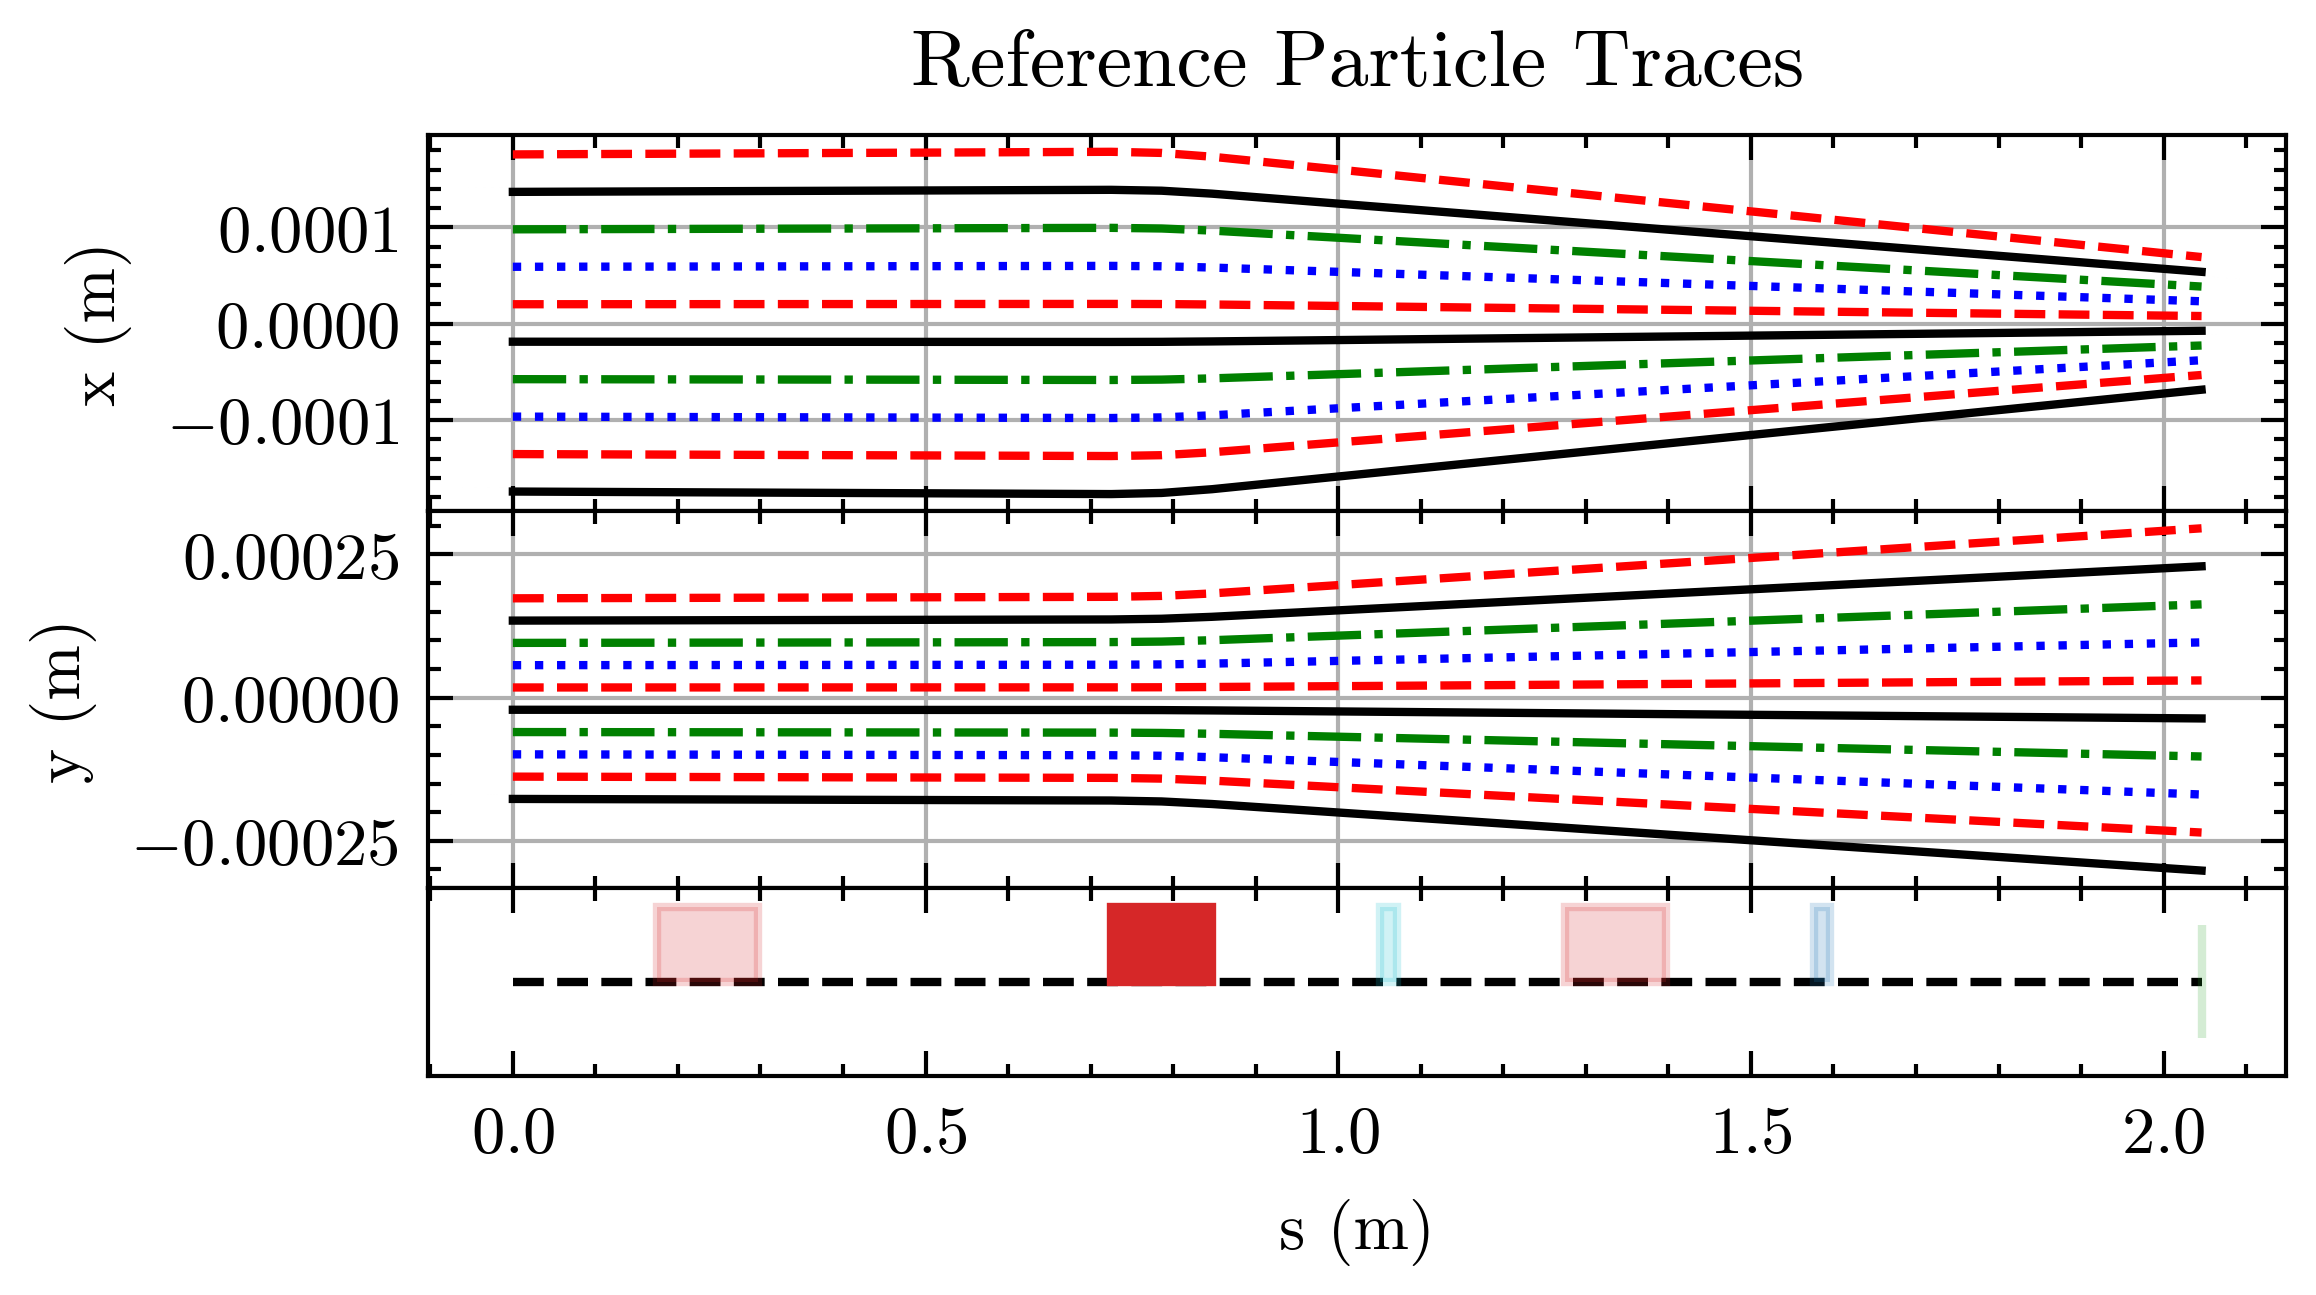

In [6]:
fig = plt.figure(figsize=(4, 2.3))
ares_ea.plot_overview(incoming=incoming_beam, fig=fig, resolution=0.1)

<h3 style="color: #b51f2a">1.2 Gradient-based optimisation</h3>
<img src="fig/cheetah_gradient.png" style="width:90%; margin:auto;"/>


<h4 style="color: #b51f2a">1.2.1 Simple example of gradient-based optimisation (without normalisation)</h4>

We start by creating the lattice section and incoming beam.


In [7]:
ares_ea = cheetah.Segment.from_lattice_json("data/ARESlatticeStage3v1_9.json").subcell(
    "AREASOLA1", "AREABSCR1"
)

In [8]:
ares_ea

Segment(elements=ModuleList(
  (0): Marker(name='AREASOLA1')
  (1): Drift(length=tensor(0.1750), tracking_method='cheetah', name='Drift_AREASOLA1')
  (2): Quadrupole(length=tensor(0.1220), k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM1')
  (3): Drift(length=tensor(0.4280), tracking_method='cheetah', name='Drift_AREAMQZM1')
  (4): Quadrupole(length=tensor(0.1220), k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM2')
  (5): Drift(length=tensor(0.2040), tracking_method='cheetah', name='Drift_AREAMQZM2')
  (6): VerticalCorrector(length=tensor(0.0200), angle=tensor(0.), name='AREAMCVM1')
  (7): Drift(length=tensor(0.2040), tracking_method='cheetah', name='Drift_AREAMCVM1')
  (8): Quadrupole(length=tensor(0.1220), k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM3')
  (9): Drift(length=t

In [9]:
incoming_beam = cheetah.ParticleBeam.from_astra("data/ACHIP_EA1_2021.1351.001")
incoming_beam

ParticleBeam(particles=tensor([[ 5.0896e-08,  5.9917e-09, -5.4731e-07,  ..., -0.0000e+00,
          2.2205e-16,  1.0000e+00],
        [ 6.1503e-05,  6.2810e-07, -5.5022e-07,  ...,  2.1870e-06,
         -1.0257e-03,  1.0000e+00],
        [ 2.3025e-08,  6.3879e-09,  4.4044e-05,  ...,  6.8509e-07,
          1.1856e-03,  1.0000e+00],
        ...,
        [ 2.0862e-04,  5.5063e-06,  2.0189e-04,  ...,  8.3149e-07,
         -5.4731e-04,  1.0000e+00],
        [ 5.6475e-05,  1.2176e-06,  2.7788e-04,  ...,  1.1890e-06,
          1.4368e-03,  1.0000e+00],
        [-6.2661e-05, -2.3784e-06,  2.1643e-04,  ...,  6.5793e-06,
         -1.8158e-03,  1.0000e+00]]), energy=107315904.0, particle_charges=tensor([5.0000e-18, 5.0000e-18, 5.0000e-18,  ..., 5.0000e-18, 5.0000e-18,
        5.0000e-18]), survival_probabilities=tensor([1., 1., 1.,  ..., 1., 1., 1.]), species=Species(name='electron', num_elementary_charges=tensor(-1), mass_eV=tensor(510998.9375)))

<h4 style="color: #b51f2a">1.2.1 Simple example of gradient-based optimisation (without normalisation)</h4>
By default, _Cheetah_ assumes that no part of its simulation requires differentiation and therefore does not track gradients, all parameters are of type `torch.Tensor`. To enable gradient tracking for parameters you would like to optimise over, you need to wrap them in `torch.nn.Parameter`, either when creating your elements and beams, or later on.

In this example, we would like to optimise over the settings of three quadrupoles and two steerers in the experimental area at the _ARES_ accelerator facility at DESY. In this case, we will need to redefine the `k1` and `angle` parameters of the magnets as `torch.nn.Parameter`.

**Note:** You could simply wrap the value of the parameters as the value it already has, e.g.

```python
ares_ea.AREAMQZM1.k1 = nn.Parameter(ares_ea.AREAMQZM1.k1)
```


In [10]:
ares_ea.AREAMQZM1.k1 = nn.Parameter(ares_ea.AREAMQZM1.k1)
ares_ea.AREAMQZM2.k1 = nn.Parameter(ares_ea.AREAMQZM2.k1)
ares_ea.AREAMCVM1.angle = nn.Parameter(ares_ea.AREAMCVM1.angle)
ares_ea.AREAMQZM3.k1 = nn.Parameter(ares_ea.AREAMQZM3.k1)
ares_ea.AREAMCHM1.angle = nn.Parameter(ares_ea.AREAMCHM1.angle)

<h4 style="color: #b51f2a">1.2.1 Simple example of gradient-based optimisation (without normalisation)</h4>

Next, we define the function that will do the actual optimisation. The goal of our optimisation is to tune the transverse beam parameters `[mu_x, sigma_x, mu_y, sigma_y]` towards some target beam parameters on a diagnostic screen at the end of the considered lattice segment. Hence, we pass the target beam parameters to the `train` function and make use of _PyTorch_'s `torch.nn.function.mse_loss` function. Note that we can easily make use of _PyTorch_'s `Adam` optimiser implementation. As a result the following code looks very similar to a standard _PyTorch_ optimisation loop for the training of neural networks.


In [11]:
def train(num_steps: int, target_beam_parameters: torch.Tensor, lr=0.1) -> dict:
    beam_parameter_history = []
    magnet_setting_history = []
    loss_history = []

    optimizer = torch.optim.Adam(ares_ea.parameters(), lr=lr)

    for _ in range(num_steps):
        optimizer.zero_grad()

        outgoing_beam = ares_ea.track(incoming_beam)

        observed_beam_parameters = torch.stack(
            [
                outgoing_beam.mu_x,
                outgoing_beam.sigma_x,
                outgoing_beam.mu_y,
                outgoing_beam.sigma_y,
            ]
        )
        loss = F.mse_loss(observed_beam_parameters, target_beam_parameters)

        loss.backward()

        # Log magnet settings and beam parameters
        loss_history.append(loss.item())
        beam_parameter_history.append(observed_beam_parameters.detach().numpy())
        magnet_setting_history.append(
            torch.stack(
                [
                    ares_ea.AREAMQZM1.k1,
                    ares_ea.AREAMQZM2.k1,
                    ares_ea.AREAMCVM1.angle,
                    ares_ea.AREAMQZM3.k1,
                    ares_ea.AREAMCHM1.angle,
                ]
            )
            .detach()
            .numpy()
        )
        optimizer.step()

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "magnet_settings": magnet_setting_history,
    }
    return history

<h4 style="color: #b51f2a">1.2.1 Simple example of gradient-based optimisation (without normalisation)</h4>

We now simply run the optimisation function with a target beam that is centred on the origin and focused to be as small as possible.


In [12]:
history = train(num_steps=100, target_beam_parameters=torch.zeros(4))

<h4 style="color: #b51f2a">1.2.1 Simple example of gradient-based optimisation (without normalisation)</h4>

The returned `history` dictionary allows us to plot the evolution of the optimisation process.


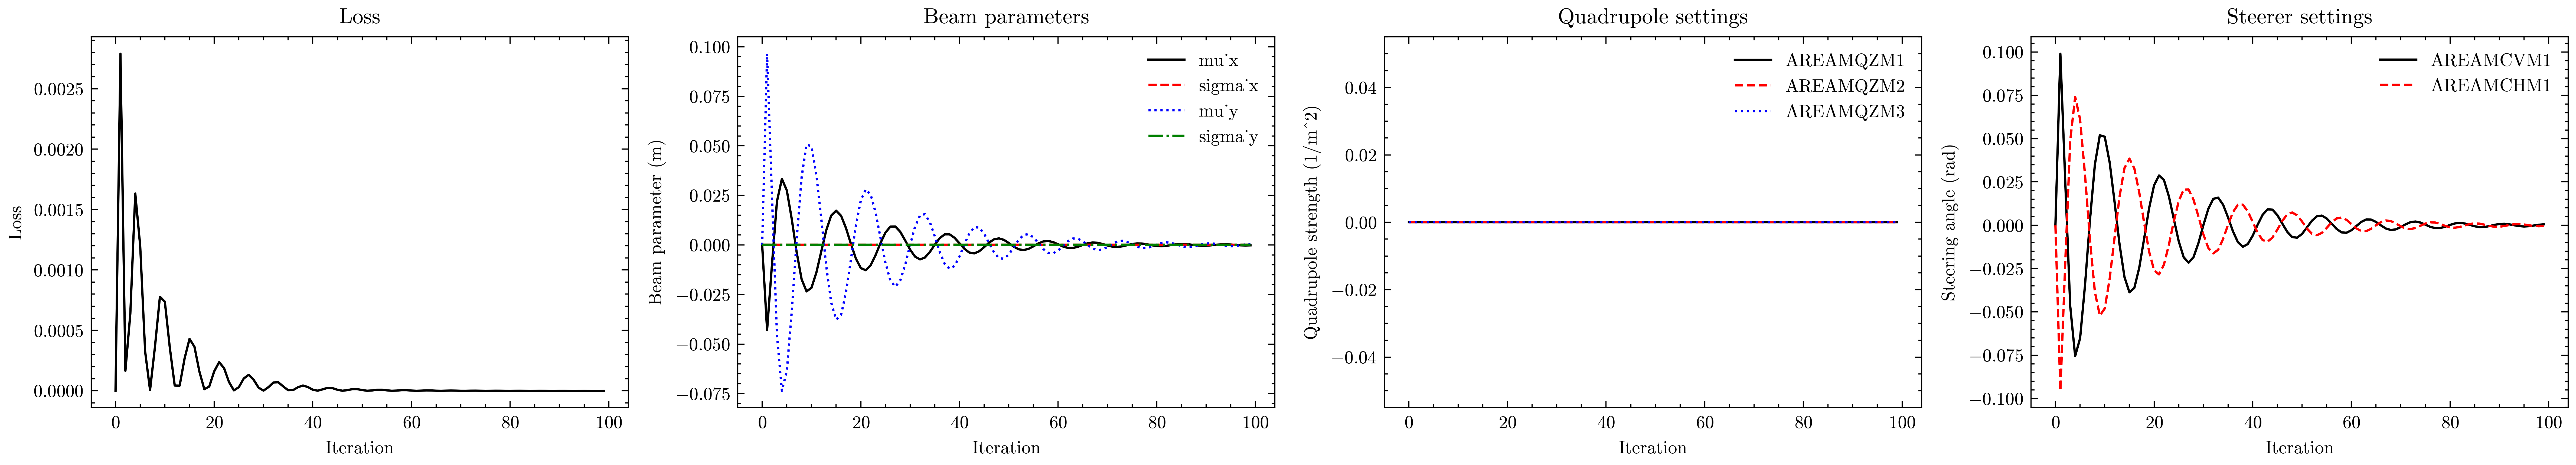

In [13]:
plot_tuning_history(history)

<h4 style="color: #b51f2a">1.2.1 Simple example of gradient-based optimisation (without normalisation)</h4>

Success! 🎉 We can observe that the optimisation converges to a solution that is close to the target beam parameters.

**However**, we can also observe that the quadrupole converges very slowly, indicating that the learning rate is too small, while the steerers keep overshooting the target, indicating that the learning rate is too large. This is a common problem in gradient-based optimisation caused by the very different scales of `k1` and `angle`, and can be solved by **normalising** the parameters under optimisation.


<h4 style="color: #b51f2a">1.2.2 Normalising parameters in gradient-based optimisation</h4>

In the following example we demonstrate how to **normalise** the parameters under optimisation with _Cheetah_. The same principle can also be applied to other custom mechanisms one might like to build around the lattice optimisation process, e.g. to add custom constraints, coupled parameters, etc.

To achieve this, we wrap the lattice section in a `torch.nn.Module` and define a `forward` function that applies the normalisation to the parameters before passing them to the lattice section.

**Note** that this time, simply for the fun of it, we also start with randomly initialised magnet settings.


In [14]:
class NormalizedARESExperimentalArea(nn.Module):
    """
    Wrapper around the AREA experimental area that holds normalised versions of the
    magnet settings as its trainable parameters.
    """

    QUADRUPOLE_LIMIT = 5.0
    STEERER_LIMIT = 6.1782e-3

    def __init__(self) -> None:
        super().__init__()
        self.ares_ea = cheetah.Segment.from_lattice_json(
            "data/ARESlatticeStage3v1_9.json"
        ).subcell("AREASOLA1", "AREABSCR1")

        self.normalized_quadrupole_strengths = nn.Parameter(torch.randn(3) * 2 - 1)
        self.normalized_steering_angles = nn.Parameter(torch.randn(2) * 2 - 1)

    def forward(self, incoming_beam: cheetah.Beam):
        self.ares_ea.AREAMQZM1.k1 = (
            self.normalized_quadrupole_strengths[0] * self.QUADRUPOLE_LIMIT
        )
        self.ares_ea.AREAMQZM2.k1 = (
            self.normalized_quadrupole_strengths[1] * self.QUADRUPOLE_LIMIT
        )
        self.ares_ea.AREAMCVM1.angle = (
            self.normalized_steering_angles[0] * self.STEERER_LIMIT
        )
        self.ares_ea.AREAMQZM3.k1 = (
            self.normalized_quadrupole_strengths[2] * self.QUADRUPOLE_LIMIT
        )
        self.ares_ea.AREAMCHM1.angle = (
            self.normalized_steering_angles[1] * self.STEERER_LIMIT
        )

        return self.ares_ea.track(incoming_beam)

In [15]:
normalized_ares_ea = NormalizedARESExperimentalArea()

<h4 style="color: #b51f2a">1.2.2 Normalising parameters in gradient-based optimisation</h4>

We then redefine the `train` function to use the `torch.nn.Module` instead of the lattice section directly.

**Note** that we also chose to apply normalisation to the beam parameters. This is not strictly necessary, but can help to improve the stability of the optimisation process.


In [16]:
def train_normalized(num_steps: int, target_beam_parameters: torch.Tensor):
    beam_parameter_history = []
    magnet_setting_history = []
    loss_history = []

    optimizer = torch.optim.Adam(normalized_ares_ea.parameters(), lr=1e-1)

    for _ in range(num_steps):
        optimizer.zero_grad()

        outgoing_beam = normalized_ares_ea(incoming_beam)
        observed_beam_parameters = torch.stack(
            [
                outgoing_beam.mu_x,
                outgoing_beam.sigma_x,
                outgoing_beam.mu_y,
                outgoing_beam.sigma_y,
            ]
        )
        loss = F.mse_loss(
            observed_beam_parameters / 2e-3, target_beam_parameters / 2e-3
        )

        loss.backward()

        # Log magnet settings and beam parameters
        loss_history.append(loss.item())
        beam_parameter_history.append(observed_beam_parameters.detach().numpy())
        magnet_setting_history.append(
            torch.stack(
                [
                    normalized_ares_ea.ares_ea.AREAMQZM1.k1,
                    normalized_ares_ea.ares_ea.AREAMQZM2.k1,
                    normalized_ares_ea.ares_ea.AREAMCVM1.angle,
                    normalized_ares_ea.ares_ea.AREAMQZM3.k1,
                    normalized_ares_ea.ares_ea.AREAMCHM1.angle,
                ]
            )
            .detach()
            .numpy()
        )

        optimizer.step()

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "magnet_settings": magnet_setting_history,
    }
    return history

<h4 style="color: #b51f2a">1.2.2 Normalising parameters in gradient-based optimisation</h4>

Now we run or new `train_normalized` function with the same target beam as before.


In [17]:
history = train_normalized(num_steps=200, target_beam_parameters=torch.zeros(4))

<h4 style="color: #b51f2a">1.2.2 Normalising parameters in gradient-based optimisation</h4>

Then we plot the evolution of the optimisation process again.


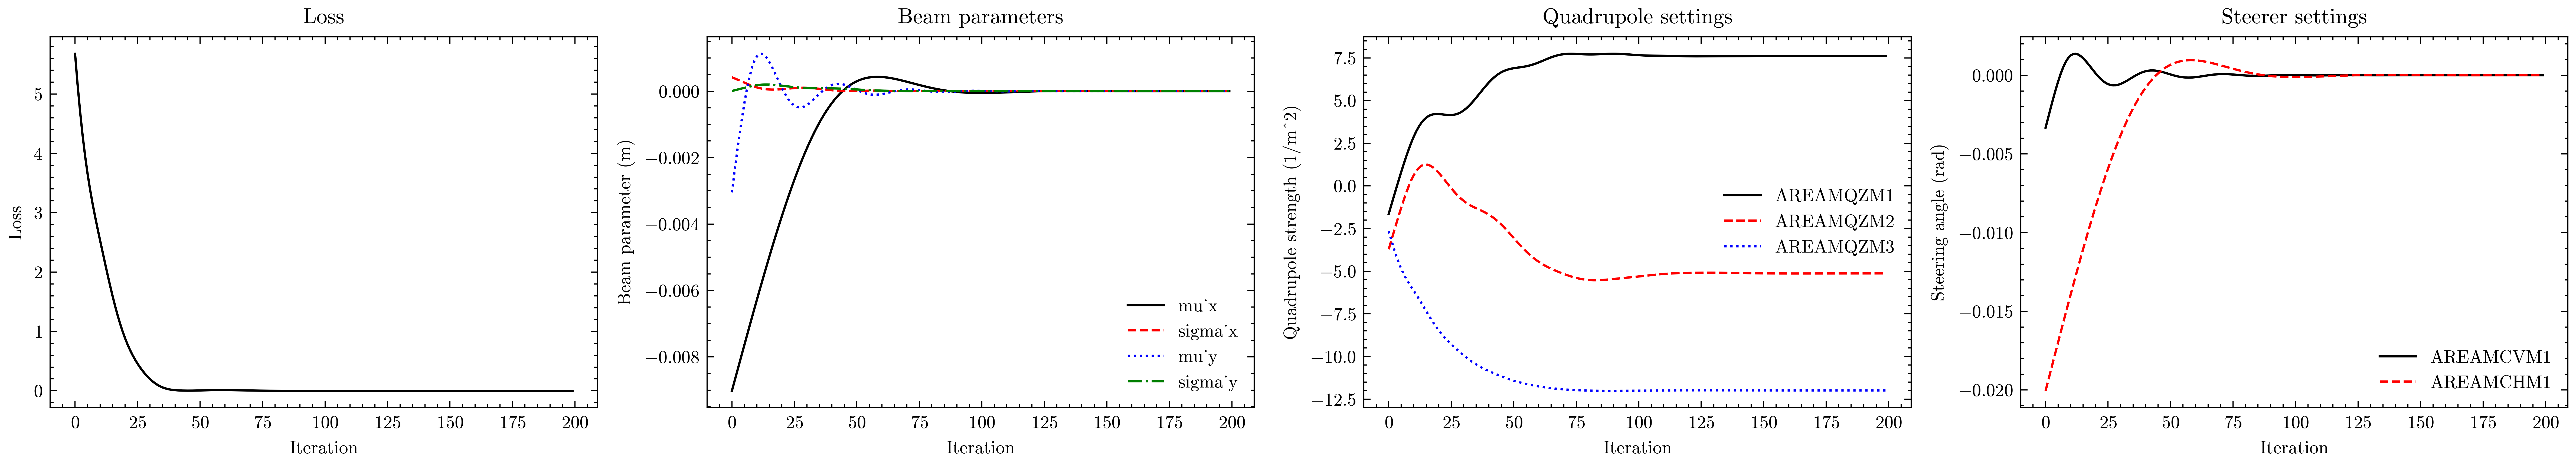

In [18]:
plot_tuning_history(history)

As you can see this already looks much better than it did without normalisation.


<h2 style="color: #b51f2a">Summary of gradient-based optimisation</h2>

- **Goal**: Optimize magnet settings to tune beam parameters efficiently.
- **How Cheetah is Used**:
  - Uses PyTorch’s automatic differentiation to compute gradients for accelerator tuning.
  - Implements Adam optimizer for fast convergence of magnet settings.
- **Advantages**:
  - Faster than black-box optimization, allowing quick optimization with large parameter spaces.
  - Achieves precise beam tuning without excessive trial-and-error experiments.

In this example, we demonstrated how to use _Cheetah_ for **magnet setting optimisation** and how to **add custom normalisation** to that same task.


<h2 style="color: #b51f2a">Example 2: gradient-based system identification (10 min)</h2>
<img src="fig/cheetah_system.png" style="width:100%; margin:auto;"/>


<h2 style="color: #b51f2a">2 Gradient-based system identification</h2>

The same principle can be applied to system identification tasks. In the following example we learn how to use _Cheetah_ for system identification at the example of determining the transverse misalignments of the three quadrupoles in the experimental area at the _ARES_ accelerator facility at DESY.


To determine the misalignments, we need

- a dataset of magnet settings,
- and the corresponding beam parameters for different settings of the quadrupoles.

Typically, this is collected with dedicated quadrupole scans

One advantage of using gradient-based optimisation for system identification is that it can easily be done using low quality data.
Such data can be collected parasitically during regular operation of the accelerator, in effect requiring no beam time.


Here we load a dataset generated by a reinforcement learning agent tuning the magnets in the EA towards a target beam. Note that this dataset would typically come from the real accelerator, but in this case we load a simulated dataset to enable us to check the identified misalignments against their ground truth values.


In [19]:
# Load data from an arbitrary tuning run
with open("data/rl_sim_33.pkl", "rb") as f:
    rl_data_sim = pickle.load(f)

<h2 style="color: #b51f2a">2 Gradient-based system identification</h2>

Similar to the previous example, we perform gradient-based optimisation of the misalignments in the Cheetah model until the model best matches our observations from the real accelerator.

- Note that the Cheetah model requires an _incoming beam_. In a real-world scenario this is not necesarily known, while the transverse position of the incoming beam affects the model and thereby the determined misalignments.
- Here, we assume we know the incoming beam exactly and use the same beam as in the dataset.
- Further below, we show that this method still works even if the incoming beam is not known exactly.


In [20]:
# Load ARES lattice and wrap it in normalisation nn.Module
class NormalizedARESEAMisalignments(nn.Module):
    """
    Wrapper around the ARES experimental area lattice that normalises the
    quadrupole misalignments.
    """

    MAX_MISALIGNMENT = 0.5e-3  # 0.5 mm

    def __init__(
        self,
        incoming: Literal[
            "rl_sim_data", "centered_rl_sim_data", "centered_astra", "uncentered_astra"
        ] = "centered_astra",
    ):
        super().__init__()

        self.ares_ea = cheetah.Segment.from_lattice_json(
            "data/ARESlatticeStage3v1_9.json"
        ).subcell("AREASOLA1", "AREABSCR1")

        # Load a beam that's close to a design beam and move it to zero mu. Zero mu is
        # assumed because we need to define origin somehow and at ARES ballistic
        # trajectory is preferred.
        if incoming == "rl_sim_data":
            incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_parameters(
                energy=torch.tensor(incoming_parameters[0]),
                mu_x=torch.tensor(incoming_parameters[1]),
                mu_px=torch.tensor(incoming_parameters[2]),
                mu_y=torch.tensor(incoming_parameters[3]),
                mu_py=torch.tensor(incoming_parameters[4]),
                sigma_x=torch.tensor(incoming_parameters[5]),
                sigma_px=torch.tensor(incoming_parameters[6]),
                sigma_y=torch.tensor(incoming_parameters[7]),
                sigma_py=torch.tensor(incoming_parameters[8]),
                sigma_tau=torch.tensor(incoming_parameters[9]),
                sigma_p=torch.tensor(incoming_parameters[10]),
                dtype=torch.float32,
            )
        elif incoming == "centered_rl_sim_data":
            incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_parameters(
                energy=torch.tensor(incoming_parameters[0]),
                mu_x=torch.tensor(0.0),
                mu_px=torch.tensor(0.0),
                mu_y=torch.tensor(0.0),
                mu_py=torch.tensor(0.0),
                sigma_x=torch.tensor(incoming_parameters[5]),
                sigma_px=torch.tensor(incoming_parameters[6]),
                sigma_y=torch.tensor(incoming_parameters[7]),
                sigma_py=torch.tensor(incoming_parameters[8]),
                sigma_tau=torch.tensor(incoming_parameters[9]),
                sigma_p=torch.tensor(incoming_parameters[10]),
                dtype=torch.float32,
            )
        else:
            raise ValueError(f"Unknown incoming beam {incoming}")

        self.normalized_misalignments_q1 = nn.Parameter(torch.randn(2) * 2 - 1)
        self.normalized_misalignments_q2 = nn.Parameter(torch.randn(2) * 2 - 1)
        self.normalized_misalignments_q3 = nn.Parameter(torch.randn(2) * 2 - 1)

    def forward(self, magnet_settings):
        # Set the magnet settings as they were in the ground truth sample
        self.ares_ea.AREAMQZM1.k1 = magnet_settings[..., 0]
        self.ares_ea.AREAMQZM2.k1 = magnet_settings[..., 1]
        self.ares_ea.AREAMCVM1.angle = magnet_settings[..., 2]
        self.ares_ea.AREAMQZM3.k1 = magnet_settings[..., 3]
        self.ares_ea.AREAMCHM1.angle = magnet_settings[..., 4]

        # Set the misalignments based on the normalised misalignments
        self.ares_ea.AREAMQZM1.misalignment = (
            self.normalized_misalignments_q1 * self.MAX_MISALIGNMENT
        )
        self.ares_ea.AREAMQZM2.misalignment = (
            self.normalized_misalignments_q2 * self.MAX_MISALIGNMENT
        )
        self.ares_ea.AREAMQZM3.misalignment = (
            self.normalized_misalignments_q3 * self.MAX_MISALIGNMENT
        )

        return self.ares_ea.track(self.incoming_beam)

<h2 style="color: #b51f2a">2 Gradient-based system identification</h2>

- Similar procedure to train as previously in the optimisation example.
- Now, the loss is computed as the error between
  - the outgoing beam parameters from the Cheetah model
  - and the observed beam parameters from the dataset.


Unlike in the previous example, it makes sense to compute the loss over batches of data, which increases optimisation speed and decreases the risk of getting stuck in local minima.
This is only possible thanks to Cheetah's native support for vectorised operations.


In [21]:
def tensor_batched(tensor: torch.Tensor, batch_size: int) -> Iterator[torch.Tensor]:
    """Yield batched slices of a tensor with a given batch size."""
    for i in range(0, tensor.size(0), batch_size):
        yield tensor[i : i + batch_size]

In [22]:
def train_normalized_system_identification(
    model: nn.Module, num_epochs: int, data: dict
) -> dict:
    misalignment_q1_history = []
    misalignment_q2_history = []
    misalignment_q3_history = []
    beam_parameter_history = []
    loss_history = []

    magnet_settings = torch.tensor(
        np.array([obs["magnets"] for obs in data["observations"]])
    )
    measured_beams = torch.tensor(
        np.array([obs["beam"] for obs in data["observations"]])
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    for _ in trange(num_epochs):
        epoch_misalignment_q1_history = []
        epoch_misalignment_q2_history = []
        epoch_misalignment_q3_history = []
        epoch_beam_parameter_history = []
        epoch_loss_history = []

        magnet_settings, measured_beams = shuffle(magnet_settings, measured_beams)
        magnet_settings_2, measured_beams_2 = shuffle(magnet_settings, measured_beams)

        optimizer.zero_grad()

        for (
            magnet_setting_batch,
            measured_beam_batch,
            magnet_setting_2_batch,
            measured_beam_2_batch,
        ) in zip(
            tensor_batched(magnet_settings, 10),
            tensor_batched(measured_beams, 10),
            tensor_batched(magnet_settings_2, 10),
            tensor_batched(measured_beams_2, 10),
        ):
            outgoing_beam_batch = model(magnet_setting_batch)
            simulated_beam_batch = torch.stack(
                [outgoing_beam_batch.mu_x, outgoing_beam_batch.mu_y], dim=1
            )
            outgoing_beam_2_batch = model(magnet_setting_2_batch)
            simulated_beam_2_batch = torch.stack(
                [outgoing_beam_2_batch.mu_x, outgoing_beam_2_batch.mu_y], dim=1
            )
            measured_beam_change_batch = (measured_beam_2_batch - measured_beam_batch)[
                :, [0, 2]
            ]
            simulated_beam_change_batch = simulated_beam_2_batch - simulated_beam_batch
            loss = F.mse_loss(
                simulated_beam_change_batch / 2e-3, measured_beam_change_batch / 2e-3
            )

            loss.backward()

            optimizer.step()

            epoch_loss_history.append(loss.detach().numpy())
            epoch_beam_parameter_history.append(simulated_beam_batch.detach().numpy())
            epoch_misalignment_q1_history.append(
                model.ares_ea.AREAMQZM1.misalignment.detach().numpy()
            )
            epoch_misalignment_q2_history.append(
                model.ares_ea.AREAMQZM2.misalignment.detach().numpy()
            )
            epoch_misalignment_q3_history.append(
                model.ares_ea.AREAMQZM3.misalignment.detach().numpy()
            )

        # Log epoch history
        loss_history.append(np.mean(epoch_loss_history))
        beam_parameter_history.append(
            np.mean(np.vstack(epoch_beam_parameter_history), axis=0)
        )
        misalignment_q1_history.append(
            np.mean(np.stack(epoch_misalignment_q1_history), axis=0)
        )
        misalignment_q2_history.append(
            np.mean(np.stack(epoch_misalignment_q2_history), axis=0)
        )
        misalignment_q3_history.append(
            np.mean(np.stack(epoch_misalignment_q3_history), axis=0)
        )

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "misalignment_q1": misalignment_q1_history,
        "misalignment_q2": misalignment_q2_history,
        "misalignment_q3": misalignment_q3_history,
    }
    return history

<h2 style="color: #b51f2a">2 Gradient-based system identification</h2>


In [23]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="rl_sim_data")
history_7 = train_normalized_system_identification(
    model=normalized_ares_ea, num_epochs=400, data=rl_data_sim
)

100%|██████████| 400/400 [00:36<00:00, 11.06it/s]


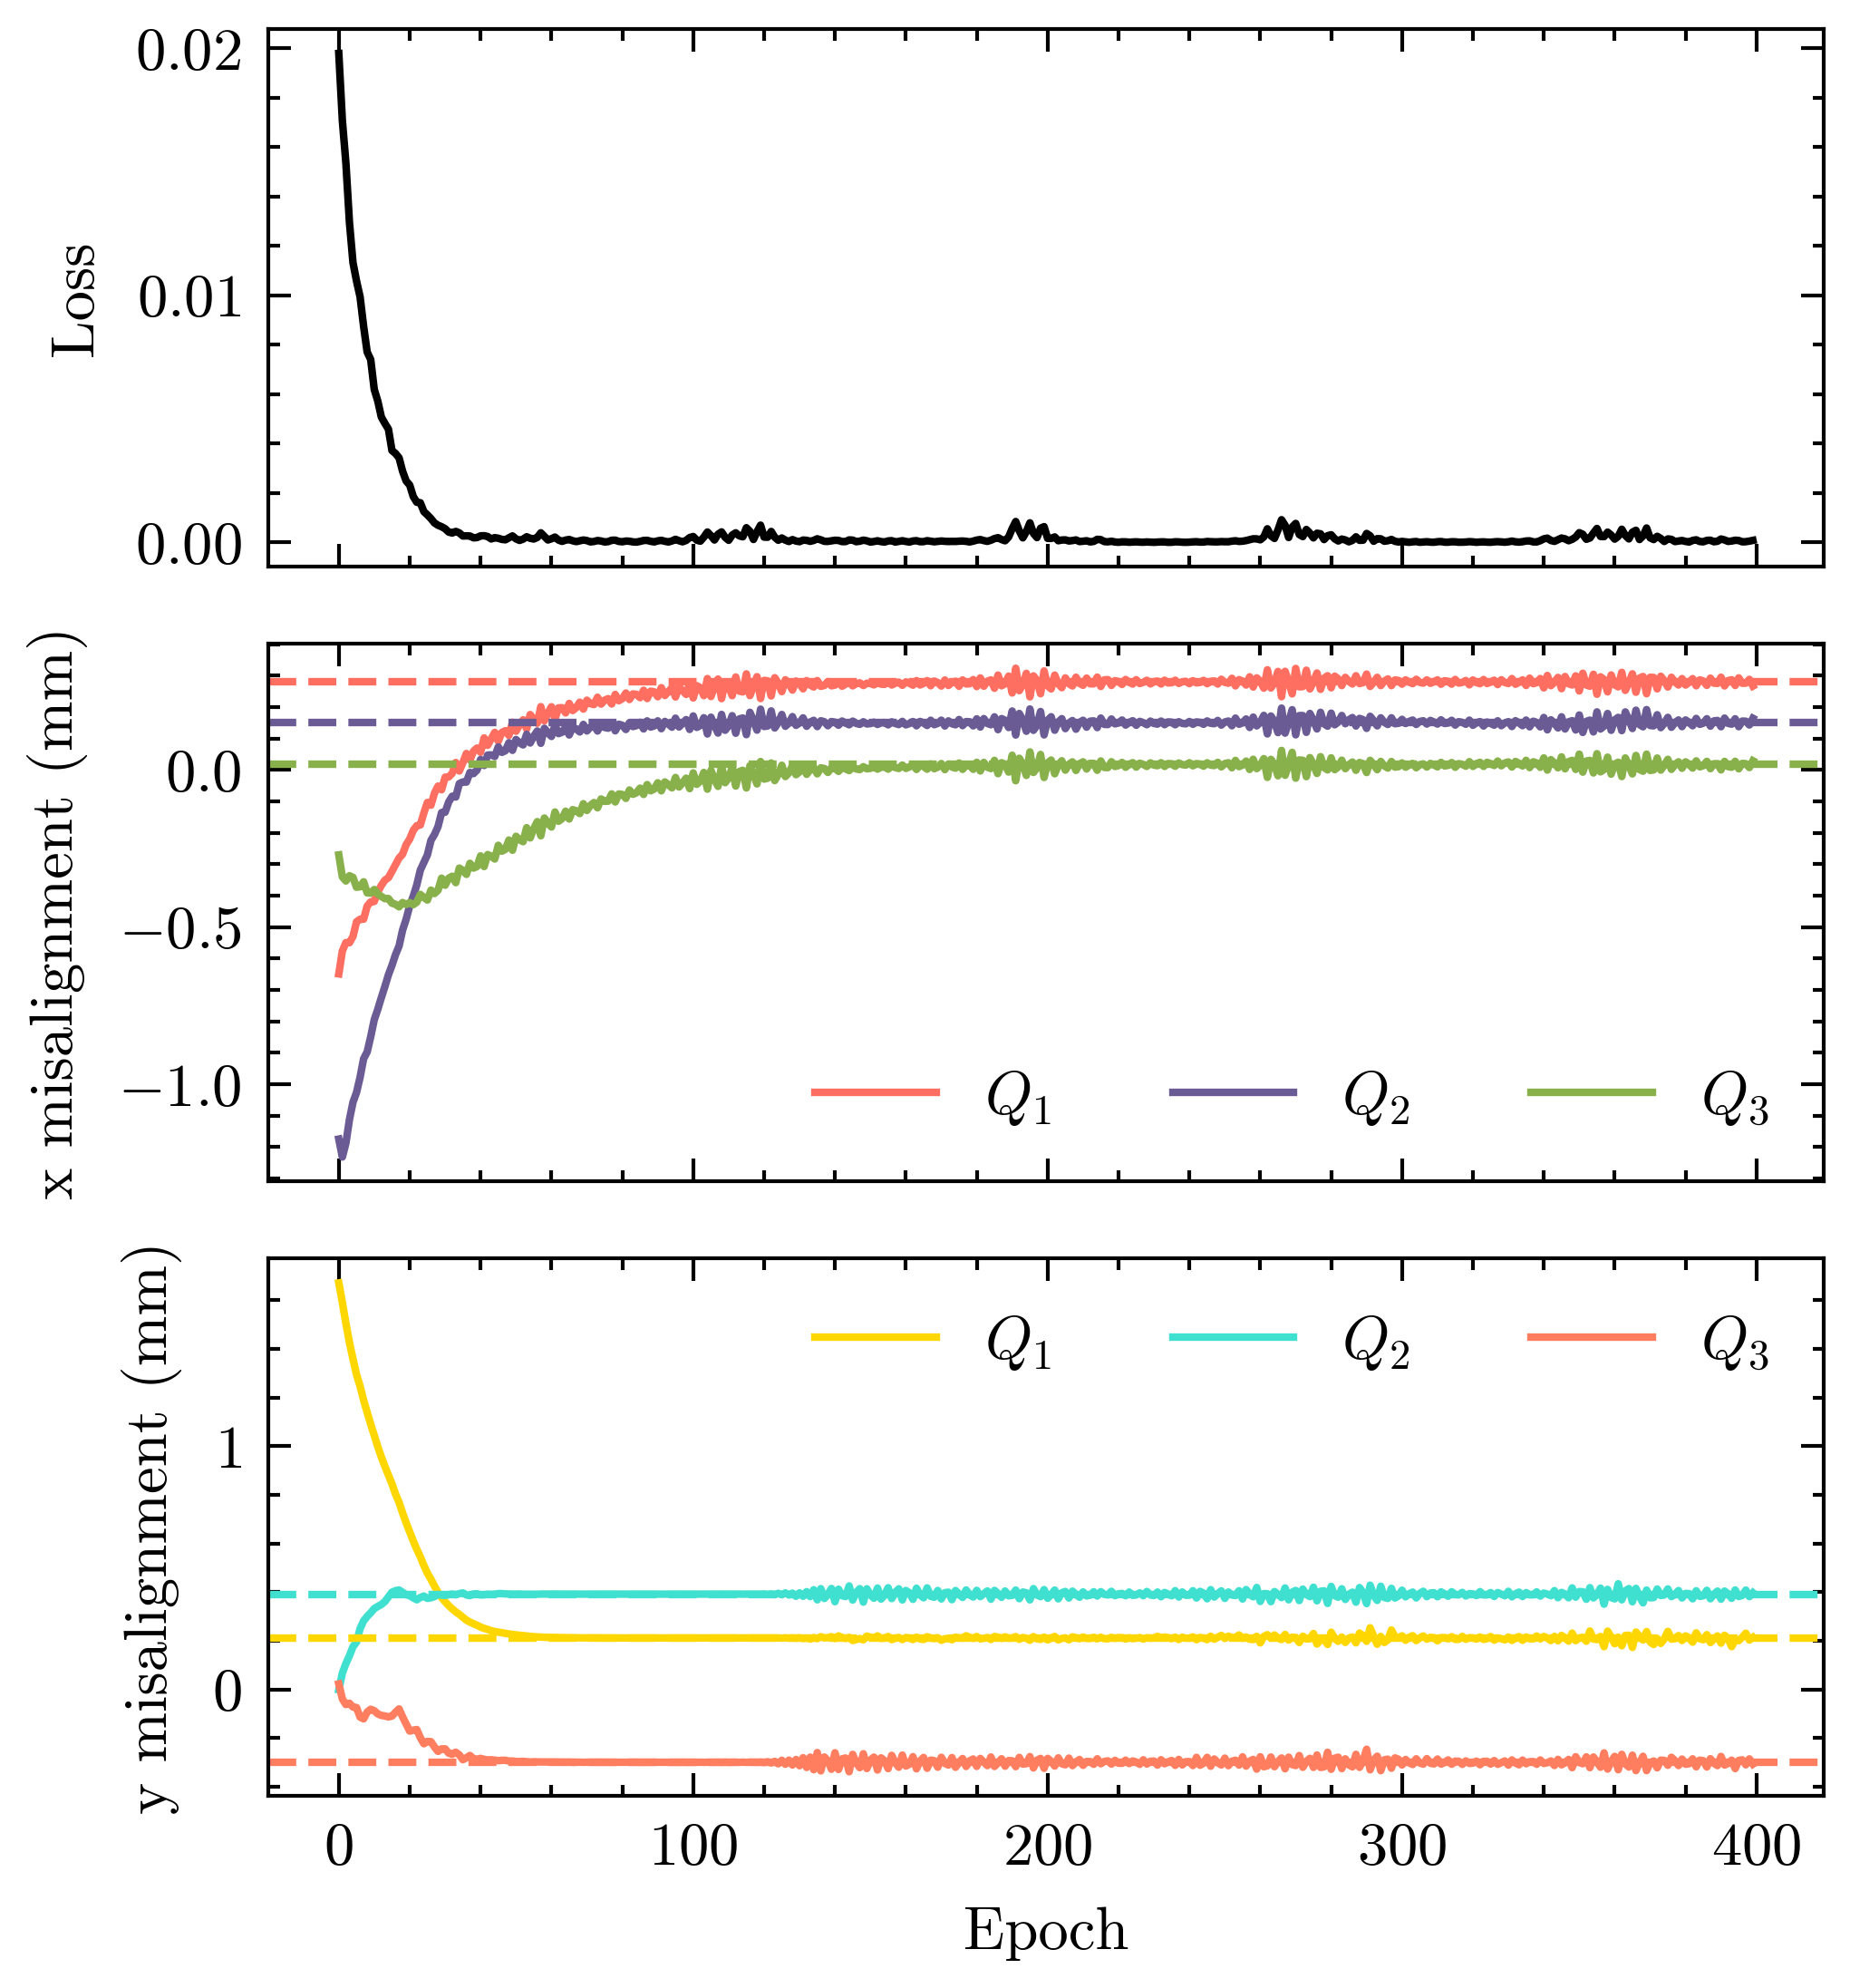

In [24]:
plot_system_identification_training(
    history_7, ground_truth=rl_data_sim["observations"][0]["misalignments"]
)

<h2 style="color: #b51f2a">2 Gradient-based system identification</h2>

- Misalignments in the Cheetah model converge towards the known ground truth misalignments.
- Gradient-based optimisation can be used for system identification tasks with _Cheetah_.

However, as previously mentioned, the incoming beam is _rarely known exactly_ in real-world scenarios.


In the following, we assume a beam that is located in origin of the transverse plane, i.e. at the reference orbit. The goal is then to determine **the misalignments with respect to this orbit**.

We can now run the same optimisation as before, but with the incoming beam set to the origin.


In [25]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_rl_sim_data")
history_sys_centered = train_normalized_system_identification(
    model=normalized_ares_ea, num_epochs=400, data=rl_data_sim
)

100%|██████████| 400/400 [00:36<00:00, 11.08it/s]


<h2 style="color: #b51f2a">2 Gradient-based system identification</h2>

And once again plot the training history.


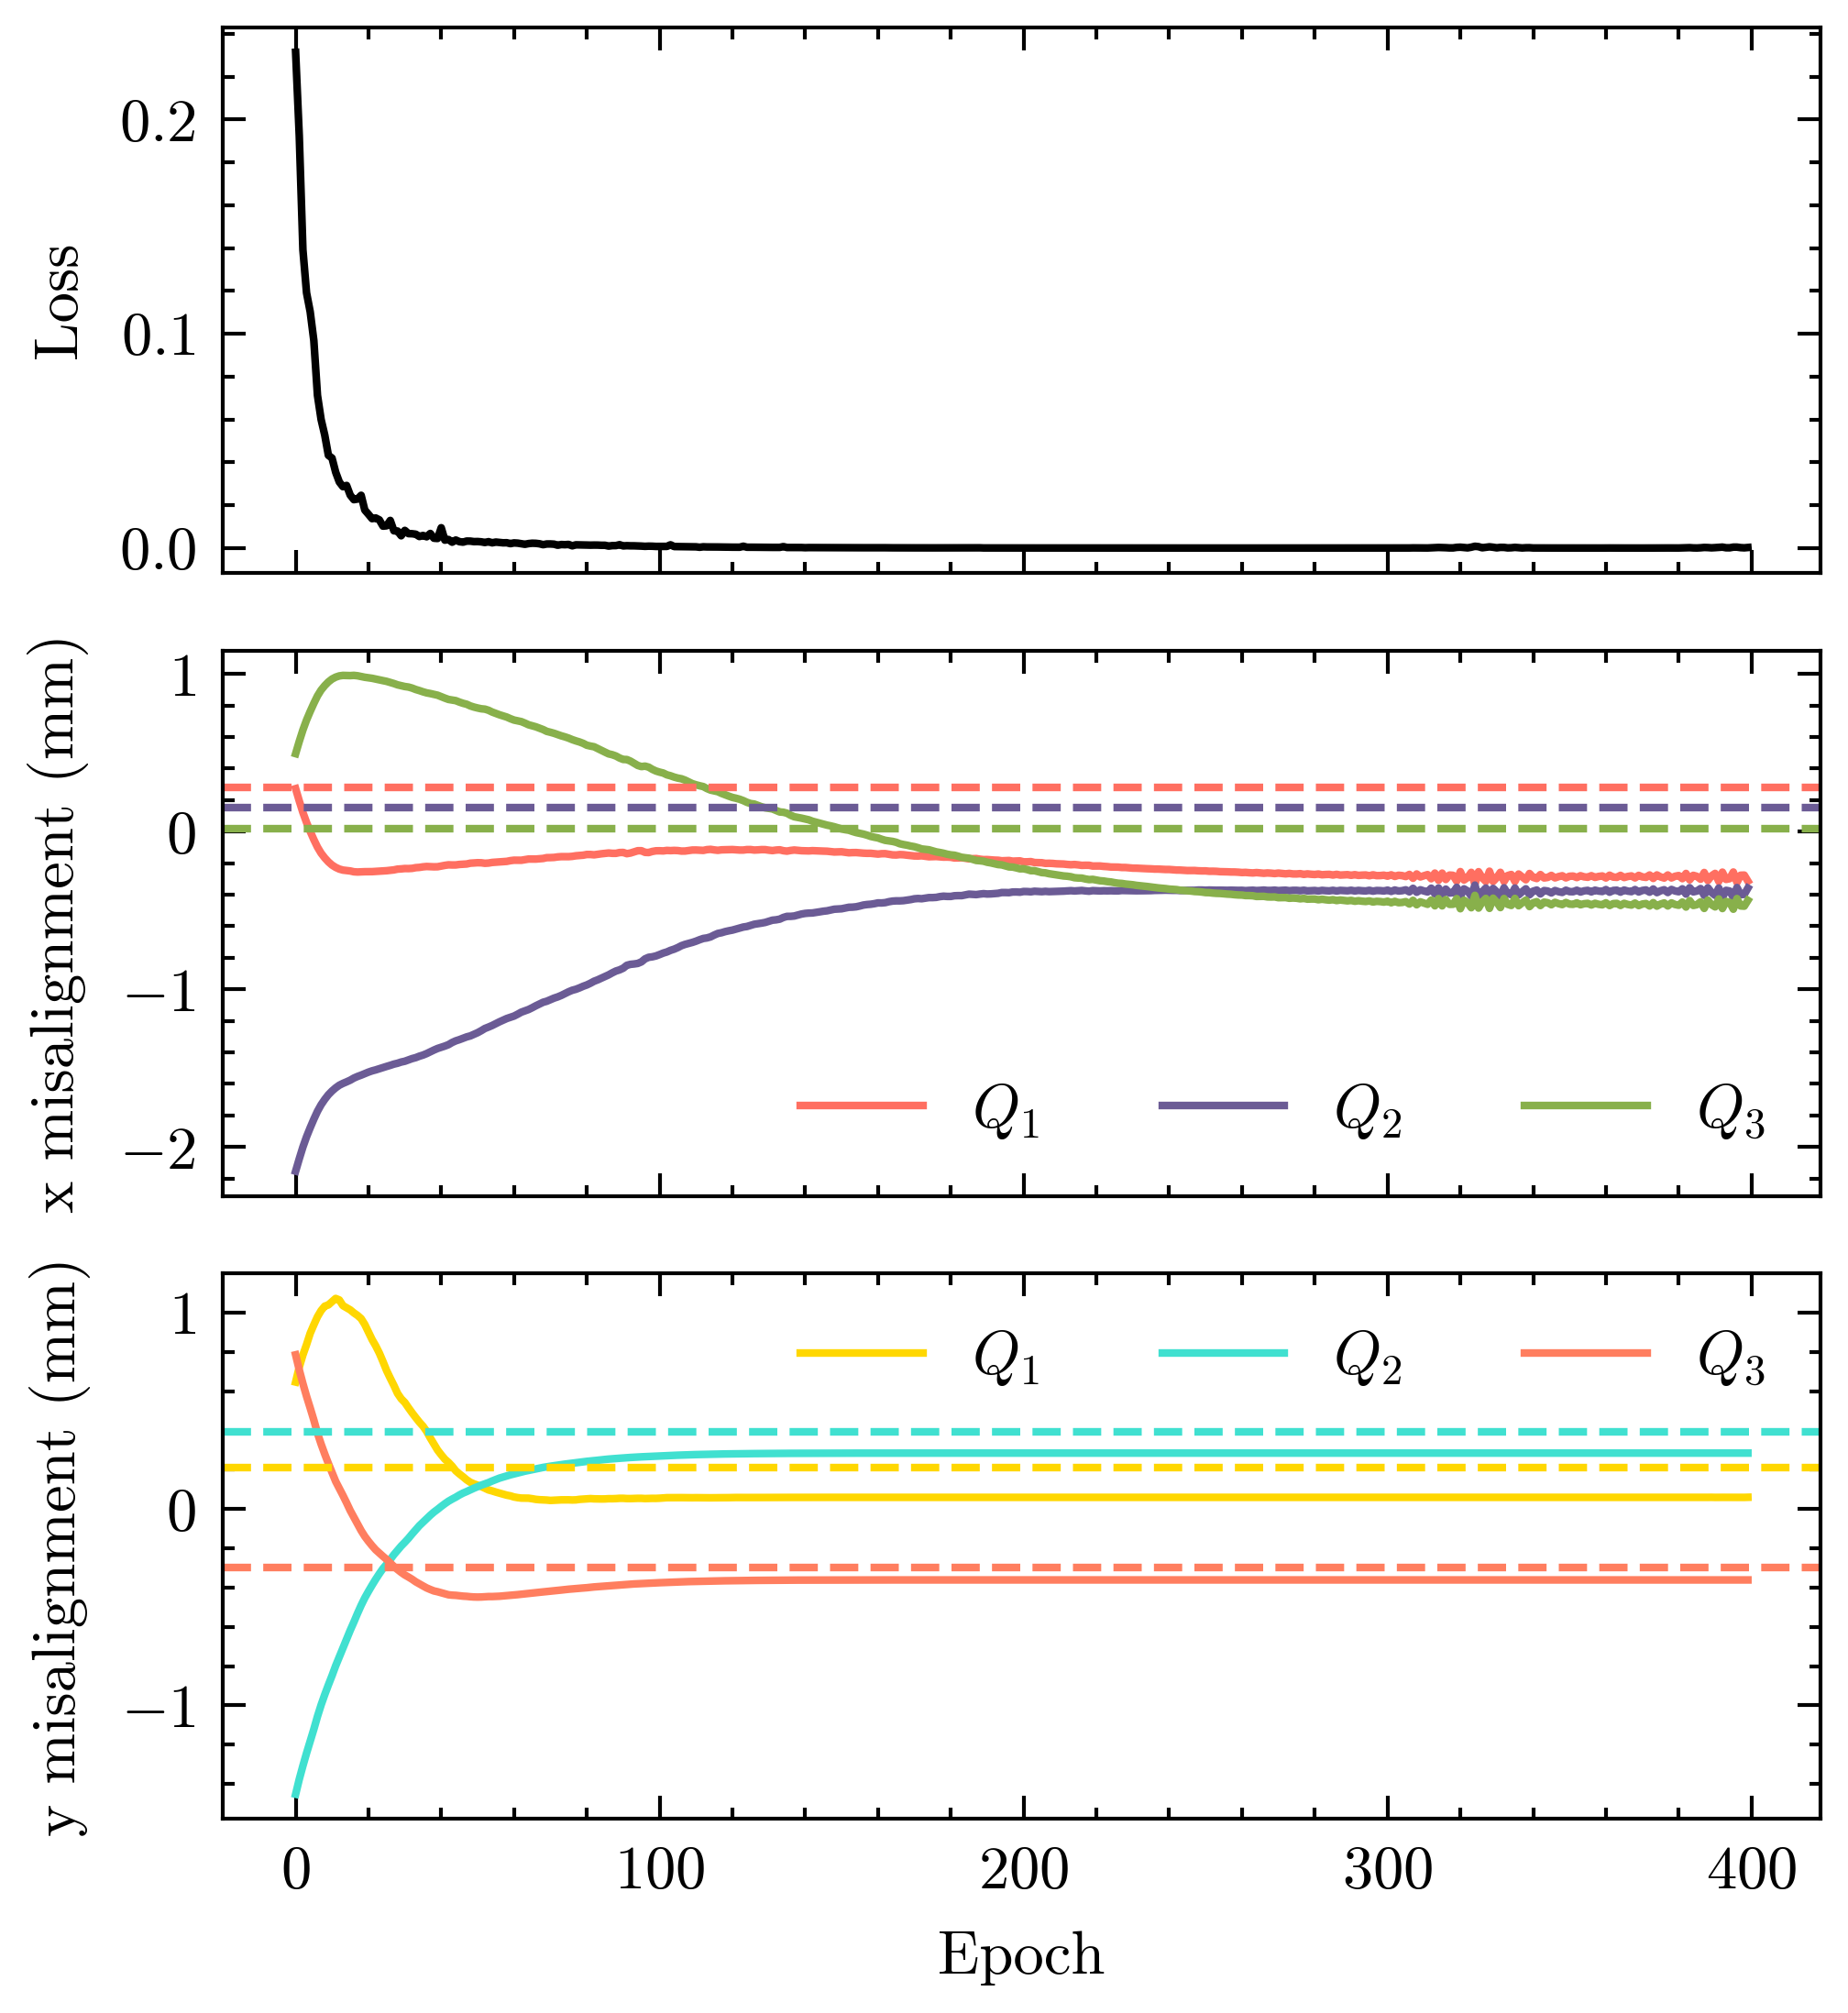

In [26]:
plot_system_identification_training(
    history_sys_centered, ground_truth=rl_data_sim["observations"][0]["misalignments"]
)

The identified misalignments are now a shifted version of the ground truth misalignments.


<h2 style="color: #b51f2a">Summary of gradient-based system identification</h2>

- **Goal**: Identify unknown accelerator parameters (e.g., misalignments, incoming beam properties).
- **How Cheetah is Used**:
  - Uses differentiability to optimize unknown system parameters based on observed beam measurements.
  - Assumes a model and adjusts unknowns to match experimental data.
- **Advantages**:
  - Enables real-world system identification without structured, time-consuming measurements.
  - Can extract meaningful parameters from existing experimental data, reducing the need for dedicated beam time.


<h2 style="color: #b51f2a">Example 3: Bayesian optimisation informed prior (10 min)</h2>

<img src="fig/cheetah_prior.png" style="width:90%; margin:auto;"/>


### Interlude: Bayesian Optimization (BO)

BO uses a statistical surrogate model (often a Guassian Process) of the objective functions to efficiently perform complex optimization tasks.

<img src="fig/bo_steps.png" style="width:80%; margin:auto;"/>


### Prior-Mean Assisting Gaussian Process (GP) Model

In BO, one often assumes a zero-mean prior for the GP model, i.e. the objective function is completely unknown.

The BO process can become more efficient if we can provide informative prior to the GP model.


In the context of particle accelerators, the prior mean functions could be

- Analytic functions
- Neural networks trained on experimental data
- Physics simulations

Cheetah's **speed** and **differentiability** make it feasible to be directly used as a prior-mean function in GP without drastically slowing down the BO inference.


### Example Case: A Simple FODO Lattice

First, let's construct a simple FODO lattice in Cheetah.


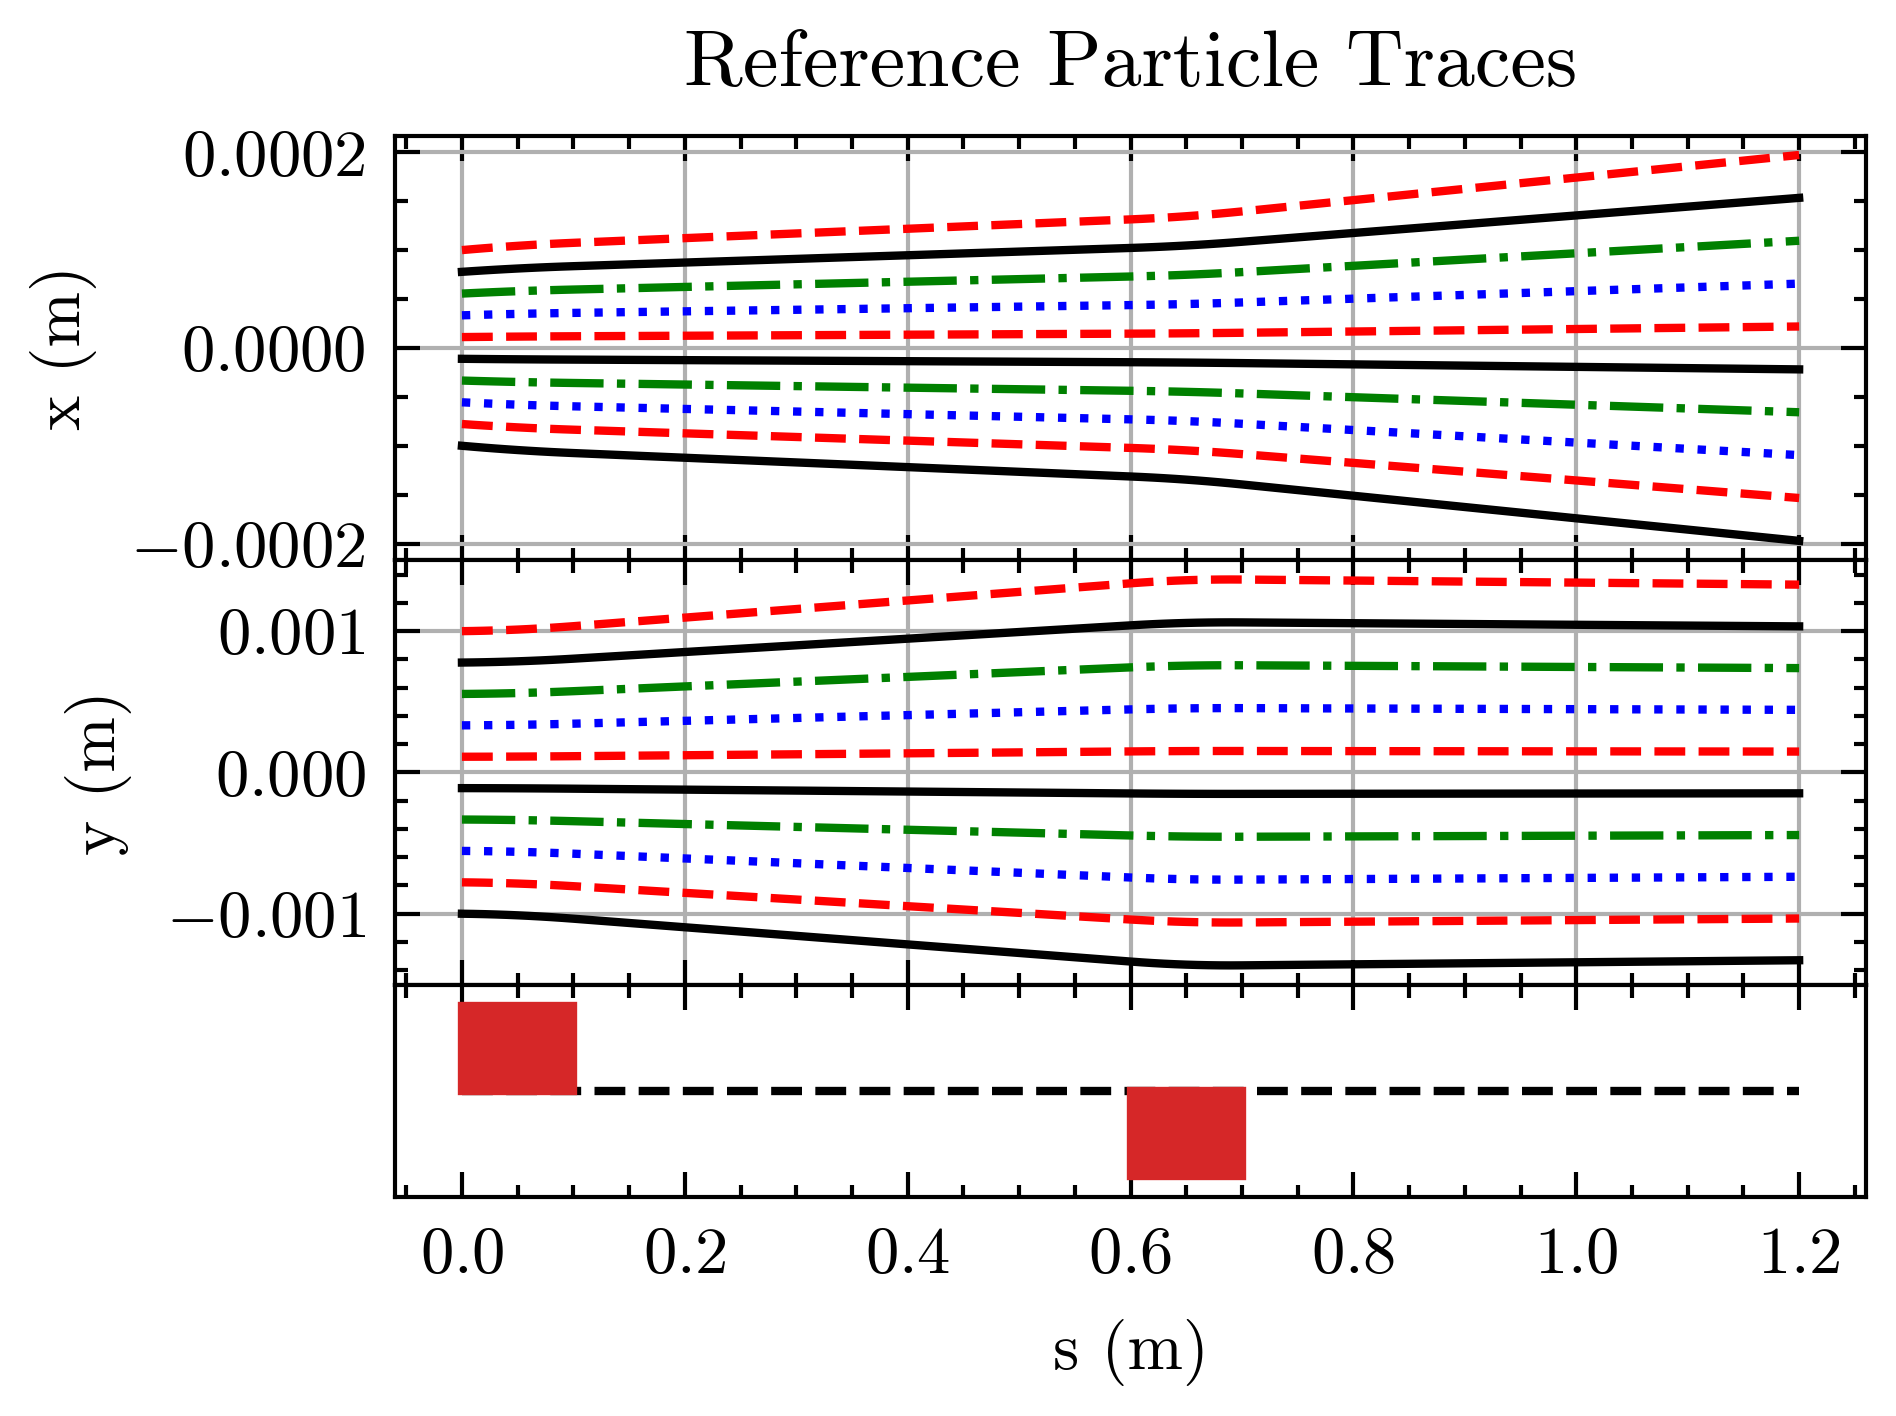

In [27]:
fodo_segment = cheetah.Segment(
    [
        cheetah.Quadrupole(length=torch.tensor(0.1), k1=torch.tensor(5.0), name="Q1"),
        cheetah.Drift(length=torch.tensor(0.5), name="D1"),
        cheetah.Quadrupole(length=torch.tensor(0.1), k1=torch.tensor(-5.0), name="Q2"),
        cheetah.Drift(length=torch.tensor(0.5), name="D2"),
    ]
)
incoming_beam = cheetah.ParameterBeam.from_parameters(
    sigma_x=torch.tensor(1e-4),
    sigma_y=torch.tensor(1e-3),
    sigma_px=torch.tensor(1e-4),
    sigma_py=torch.tensor(1e-4),
    energy=torch.tensor(100e6),
    dtype=torch.float32,
)

fodo_segment.plot_overview(incoming_beam)

Let's wrap it into a function for the [Xopt](https://github.com/xopt-org/Xopt) library.

The function takes the quadrupole strengths as a dictionary

```python
input_param={"q1": q1, "q2": q2}
```

It tracks the beam and returns the mean absolute error (MAE) of the beam sizes $\sigma_{x,y}$ at the end of the FODO segment.

The goal is then to minimize the `mae` by varying the quadrupoles `[q1,q2]`.


In [28]:
def simple_fodo_problem(
    input_param: dict[str, float],
    incoming_beam: cheetah.Beam | None = None,
    lattice_distances: dict[str, float] = {},
) -> dict[str, float]:
    if incoming_beam is None:
        incoming_beam = cheetah.ParameterBeam.from_parameters(
            sigma_x=torch.tensor(1e-4),
            sigma_y=torch.tensor(2e-3),
            sigma_px=torch.tensor(1e-4),
            sigma_py=torch.tensor(1e-4),
            energy=torch.tensor(100e6),
            dtype=torch.float32,
        )
    quad_length = torch.tensor(lattice_distances.get("quad_length", 0.1))
    drift_length = torch.tensor(lattice_distances.get("drift_length", 0.5))

    fodo_segment = cheetah.Segment(
        [
            cheetah.Quadrupole(
                length=quad_length, k1=torch.tensor(input_param["q1"]), name="Q1"
            ),
            cheetah.Drift(length=drift_length, name="D1"),
            cheetah.Quadrupole(
                length=quad_length, k1=torch.tensor(input_param["q2"]), name="Q2"
            ),
            cheetah.Drift(length=drift_length, name="D1"),
        ]
    )

    out_beam = fodo_segment(incoming_beam)

    beam_size_mae = 0.5 * (out_beam.sigma_x.abs() + out_beam.sigma_y.abs())

    return {
        "mae": beam_size_mae.detach().numpy(),
    }

Set the optimization bounds and objective function


In [29]:
vocs_config = """
    variables:
        q1: [-30, 15]
        q2: [-15, 30]
    objectives:
        mae: minimize
"""
vocs = xopt.VOCS.from_yaml(vocs_config)

incoming_beam = cheetah.ParameterBeam.from_parameters(
    sigma_x=torch.tensor(1e-3),
    sigma_y=torch.tensor(1e-3),
    sigma_px=torch.tensor(1e-4),
    sigma_py=torch.tensor(1e-4),
    energy=torch.tensor(100e6),
)
evaluator = xopt.Evaluator(
    function=simple_fodo_problem,
    function_kwargs={
        "incoming_beam": incoming_beam,
        "lattice_distances": {"drift_length": 0.7},
    },
)

### Use the basic BO to optimize the problem

First, set the config for evaluations


In [30]:
N_TRIALS = 5  # Run the evaluation multiple times to get some statistics
N_STEPS = 30  # How many optimization steps to run for each trial
START_POINT = {"q1": -20.0, "q2": 20.0}  # Use a fixed starting point

Running the optimization


In [31]:
df_bo_ucb = pd.DataFrame()  # for storing the results
for i in range(N_TRIALS):
    generator = UpperConfidenceBoundGenerator(
        beta=2.0, vocs=vocs
    )  # Use UCB acquisition
    x = xopt.Xopt(
        vocs=vocs,
        evaluator=evaluator,
        generator=generator,
        max_evaluations=N_STEPS,
    )
    # Fixed starting point
    x.evaluate_data(START_POINT)
    # Start Optimization
    for _ in tqdm.tqdm(range(N_STEPS)):
        x.step()
    # Post processing the dataframes
    x.data.index.name = "step"
    x.data["run"] = i
    x.data["best_mae"] = x.data["mae"].cummin()
    for col in x.data.columns:
        x.data[col] = x.data[col].astype(float)
    df_bo_ucb = pd.concat([df_bo_ucb, x.data])

100%|██████████| 30/30 [00:02<00:00, 10.05it/s]


#### Look at the Results


(0.0, 30.0)

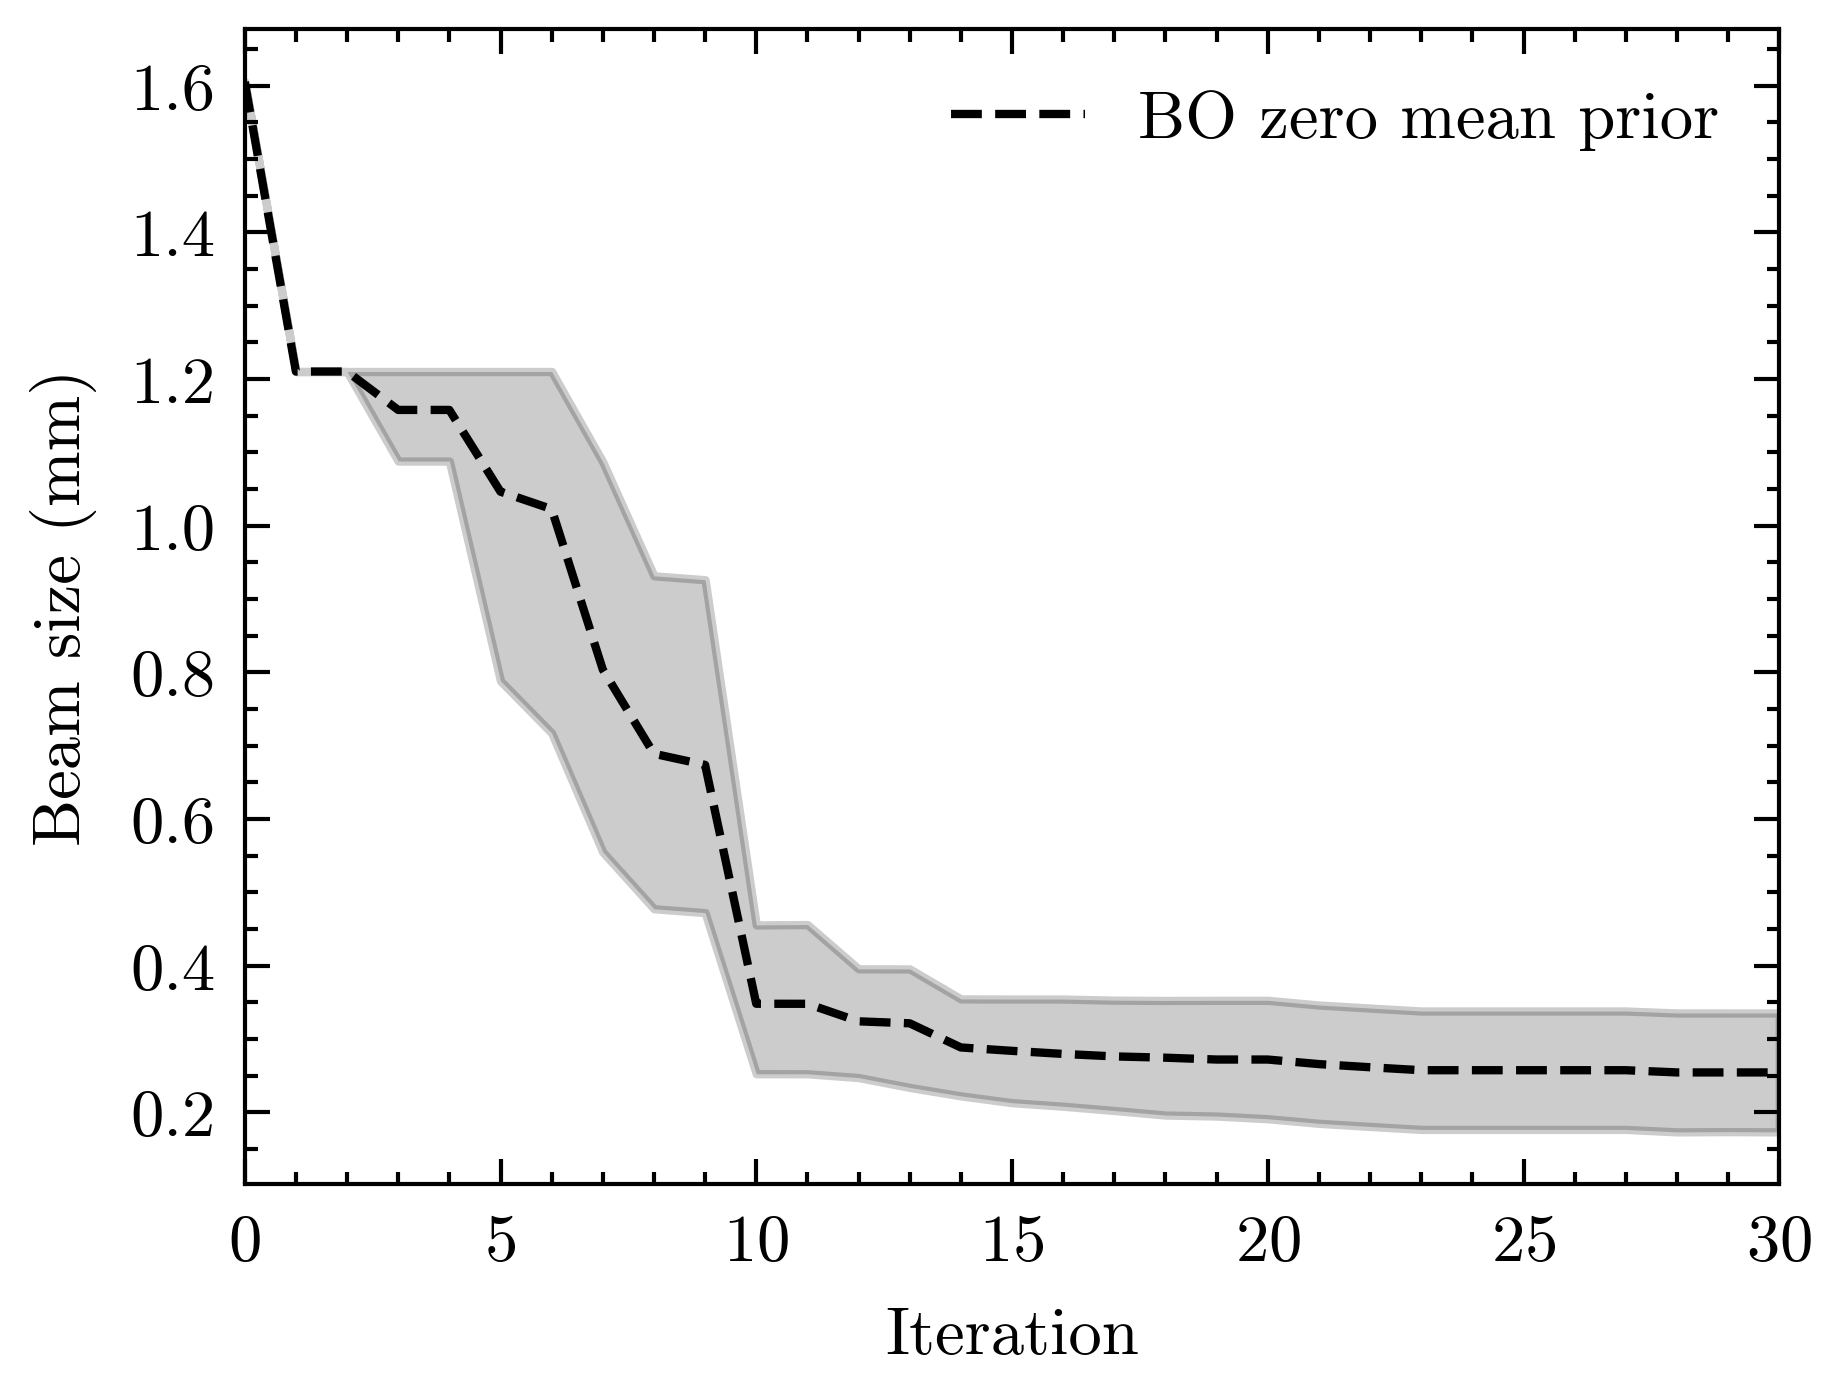

In [32]:
fig, ax = plt.subplots()
colors = sns.color_palette()
sns.lineplot(
    data=df_bo_ucb,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO zero mean prior",
    ls="--",
)
yticks = ax.get_yticks()[1:]
ax.set_yticks(np.arange(0.2, 1.8, 0.2) * 1e-3)
ax.set_yticklabels(np.arange(0.2, 1.8, 0.2).round(2))
ax.set_ylabel("Beam size (mm)")
ax.set_xlabel("Iteration")
ax.set_xlim(0, N_STEPS)

### Wrap the Cheetah Lattice as a Prior Mean Module for the GP Model


In [33]:
class FodoPriorMean(Mean):
    """FODO Lattice as a prior mean function for BO."""

    def __init__(self, incoming_beam: cheetah.Beam | None = None):
        super().__init__()
        if incoming_beam is None:
            incoming_beam = cheetah.ParameterBeam.from_parameters(
                sigma_x=torch.tensor(1e-4),
                sigma_y=torch.tensor(2e-3),
                sigma_px=torch.tensor(1e-4),
                sigma_py=torch.tensor(2e-4),
                energy=torch.tensor(100e6),
            )
        self.incoming_beam = incoming_beam
        # Build the FODO lattice
        self.Q1 = cheetah.Quadrupole(
            length=torch.tensor([0.1]), k1=torch.tensor([0.1]), name="Q1"
        )
        self.D1 = cheetah.Drift(length=torch.tensor([0.1]), name="D1")
        self.Q2 = cheetah.Quadrupole(
            length=torch.tensor([0.1]), k1=torch.tensor([0.1]), name="Q2"
        )
        self.D2 = cheetah.Drift(length=torch.tensor([0.1]), name="D2")
        self.segment = cheetah.Segment(elements=[self.Q1, self.D1, self.Q2, self.D2])

        # Introduce a free parameter for the lattice
        drift_length_constraint = Positive()
        self.register_parameter("raw_drift_length", nn.Parameter(torch.tensor(0.4)))
        self.register_prior(
            "drift_length_prior",
            SmoothedBoxPrior(0.2, 1.0),
            self._drift_length_param,
            self._set_drift_length,
        )
        self.register_constraint("raw_drift_length", drift_length_constraint)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Calculate the prior mean for the given magnet settings."""
        self.Q1.k1 = X[..., 0]  # Note that the calculation here is batched.

        self.Q2.k1 = X[..., 1]
        self.D1.length = self.drift_length
        self.D2.length = self.drift_length

        out_beam = self.segment(self.incoming_beam)
        beam_size_mae = 0.5 * (out_beam.sigma_x.abs() + out_beam.sigma_y.abs())
        return beam_size_mae

    @property
    def drift_length(self):
        return self._drift_length_param(self)

    @drift_length.setter
    def drift_length(self, value: torch.Tensor):
        self._set_drift_length(self, value)

    # Some hack to conform with gpytorch definitions
    def _drift_length_param(self, m):
        return m.raw_drift_length_constraint.transform(self.raw_drift_length)

    def _set_drift_length(self, m, value: torch.Tensor):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(m.raw_drift_length)
        m.initialize(
            raw_drift_length=m.raw_drift_length_constraint.inverse_transform(value)
        )

#### Perform the optimization using Cheetah Prior Mean


In [34]:
df_bo_cheetah = pd.DataFrame()
for i in range(N_TRIALS):
    # Create a Cheetah Prior Mean and use it for GP Construction
    prior_mean_module = FodoPriorMean()
    gp_constructor = StandardModelConstructor(
        mean_modules={"mae": prior_mean_module},
        trainable_mean_keys=["mae"],  # Allow the prior mean to be trained
    )
    generator = UpperConfidenceBoundGenerator(
        beta=2.0, vocs=vocs, gp_constructor=gp_constructor
    )
    # The rest is the same as seen before
    x = xopt.Xopt(
        vocs=vocs,
        evaluator=evaluator,
        generator=generator,
        max_evaluations=N_STEPS,
    )
    # Fixed starting point
    x.evaluate_data(START_POINT)
    # Start Optimization
    for _ in tqdm.tqdm(range(N_STEPS)):
        x.step()
    # Post processing the dataframes
    x.data.index.name = "step"
    x.data["run"] = i
    x.data["best_mae"] = x.data["mae"].cummin()
    for col in x.data.columns:
        x.data[col] = x.data[col].astype(float)
    df_bo_cheetah = pd.concat([df_bo_cheetah, x.data])

100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


#### Look at the comparison result


(0.0, 30.0)

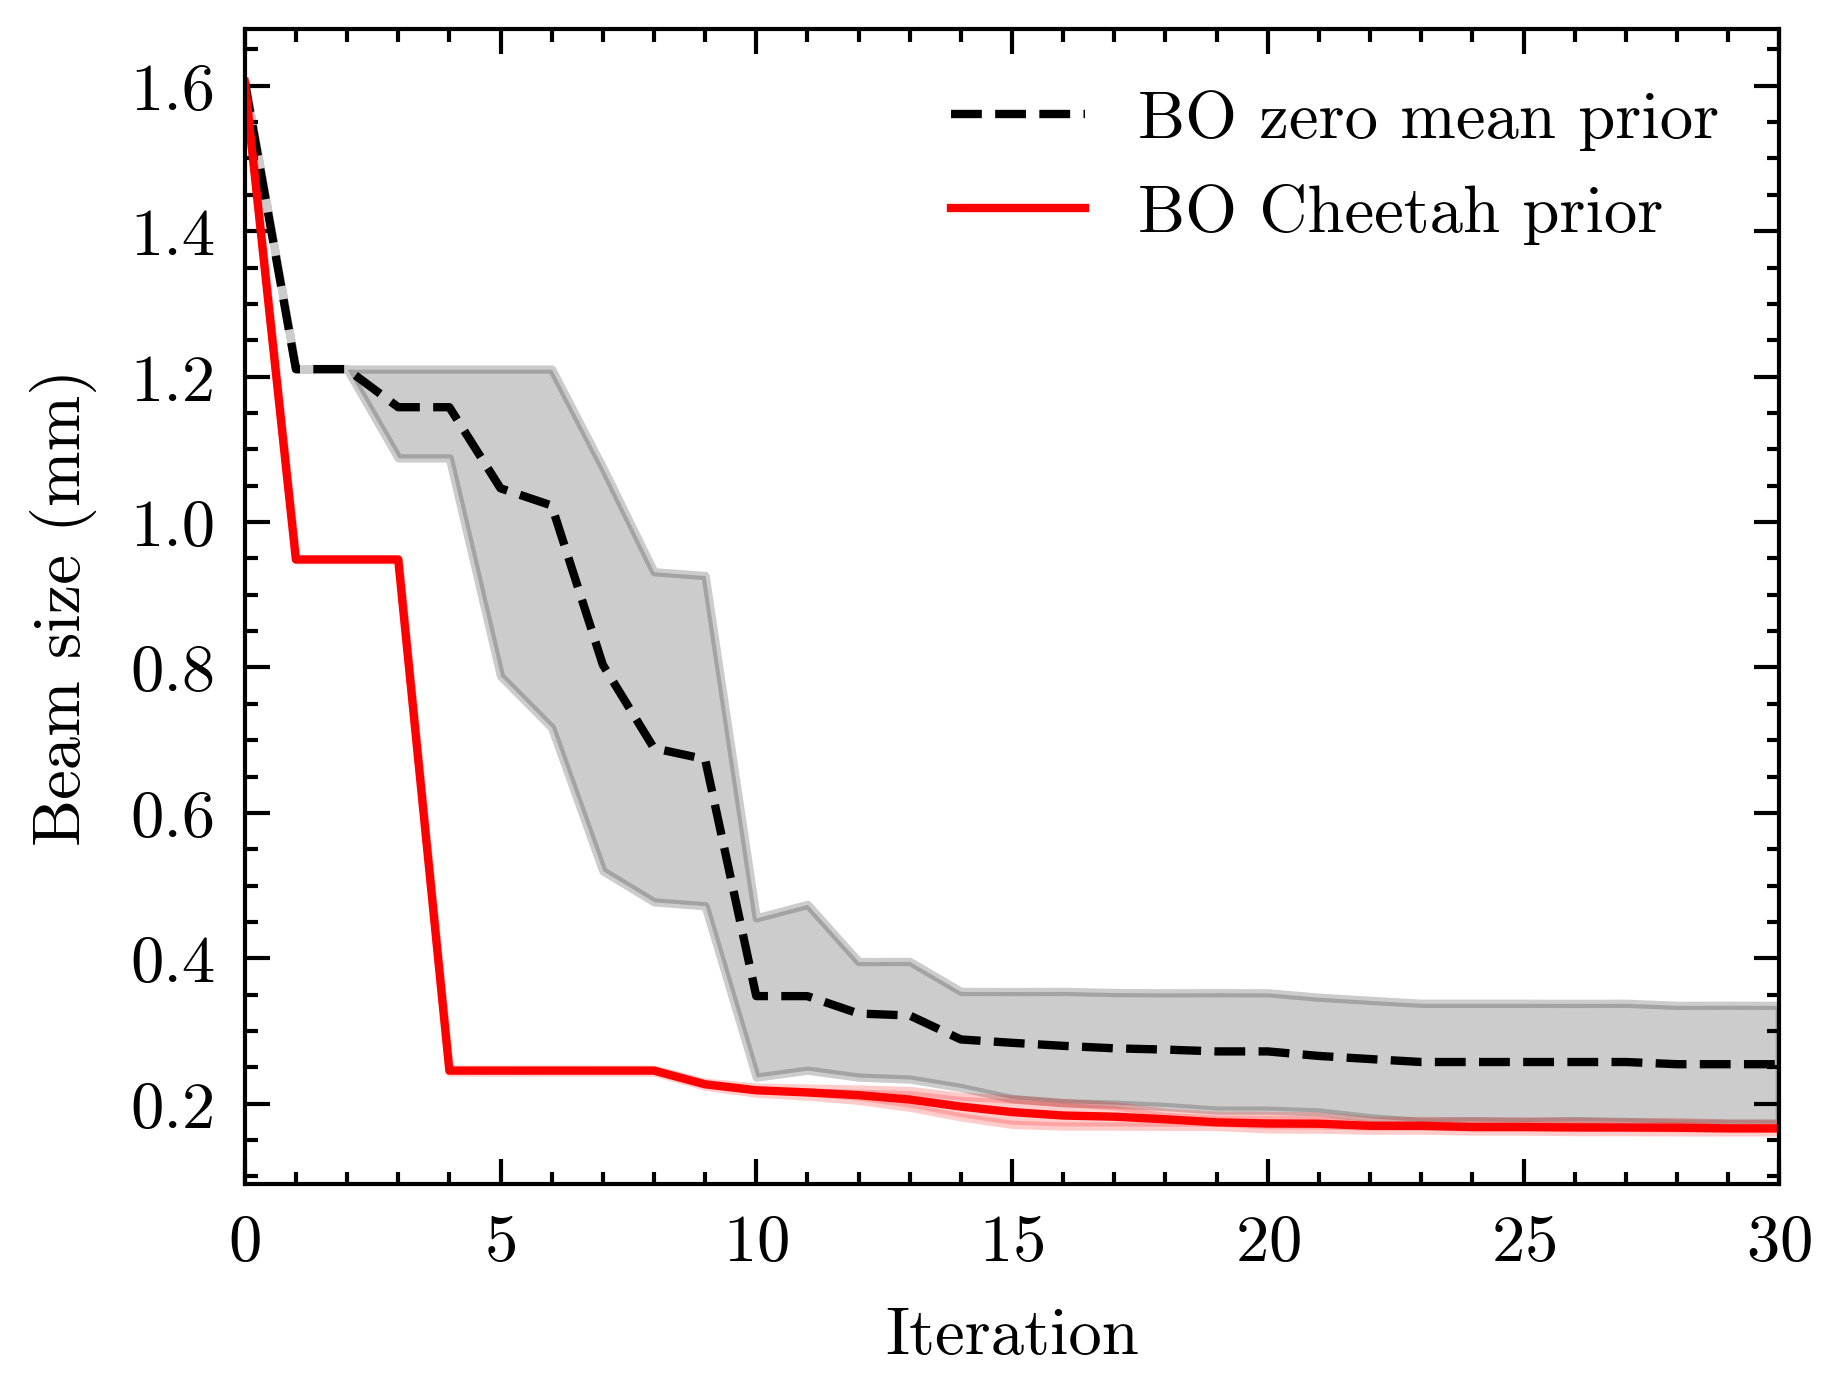

In [35]:
fig, ax = plt.subplots()
colors = sns.color_palette()
sns.lineplot(
    data=df_bo_ucb,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO zero mean prior",
    ls="--",
)
sns.lineplot(
    data=df_bo_cheetah,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO Cheetah prior",
    ls="-",
)
yticks = ax.get_yticks()[1:]
ax.set_yticks(np.arange(0.2, 1.8, 0.2) * 1e-3)
ax.set_yticklabels(np.arange(0.2, 1.8, 0.2).round(2))
ax.set_ylabel("Beam size (mm)")
ax.set_xlabel("Iteration")
ax.set_xlim(0, N_STEPS)

#### Visualizing the Mismatches in Models

Note that the Cheetah model used as the prior mean is mismatched to the problem being optimized, with

- different incoming beam
- different drift space lengths


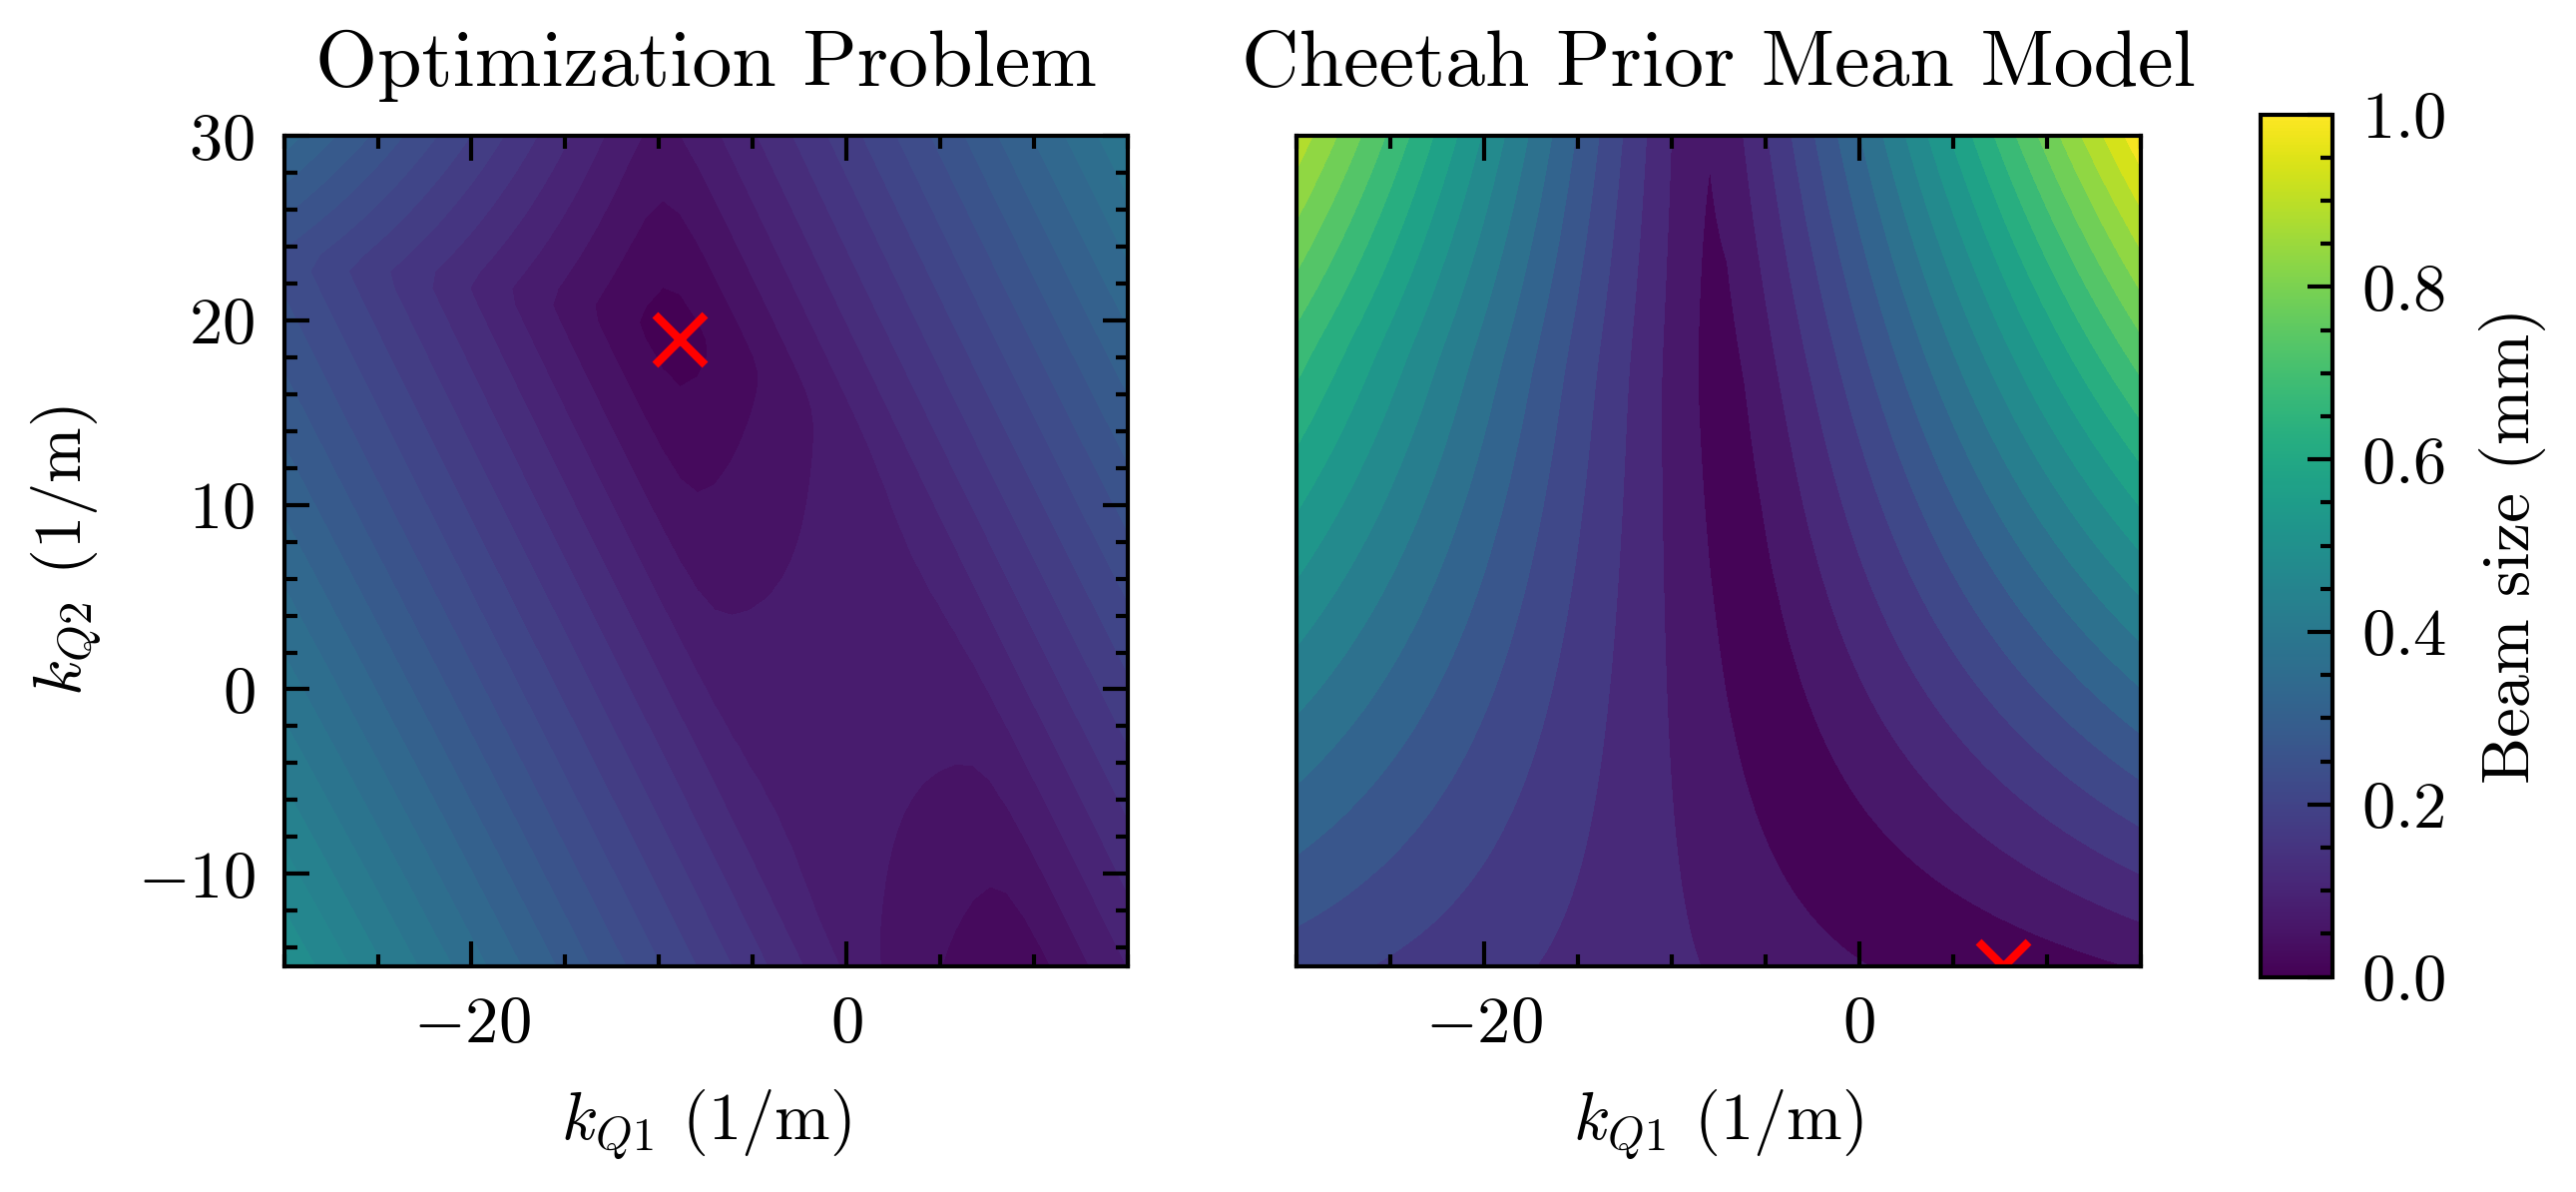

In [36]:
prior_mean_module = FodoPriorMean()
plot_parameter_space_difference(vocs, evaluator, prior_mean_module)

<h2 style="color: #b51f2a">Summary of Bayesian optimisation informed prior</h2>

- **Goal**: Improve sample efficiency in Bayesian optimization (BO) for accelerator tuning.
- **How Cheetah is Used**:
  - Provides a fast physics-based prior mean for the Gaussian process in BO.
  - Reduces unnecessary exploration in high-dimensional parameter spaces.
- **Advantages**:
  - Faster convergence of BO compared to using a constant mean or simplex methods.
  - Reduces the number of required evaluations, making BO feasible for complex tasks.


<h2 style="color: #b51f2a">Example 4: generative phase space reconstruction (10 min)</h2>
<img src="fig/gpsr_pipeline.png" style="width:90%; margin:auto;"/>
<style>
div.cell {
    overflow-y: scroll;
    max-height: 500px;
}
</style>


### Diagnostics for generative phase space reconstruction (GPSR)

<img src="fig/gpsr_scan.png" style="width:90%; margin:auto;"/>


### Example GPSR Dataset


(<Figure size 4500x3360 with 20 Axes>,
 array([[<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: xlabel='x (mm)', ylabel='y (mm)'>,
         <Axes: xlabel='x (mm)'>, <Axes: xlabel='x (mm)'>,
         <Axes: xlabel='x (mm)'>, <Axes: xlabel='x (mm)'>]], dtype=object))

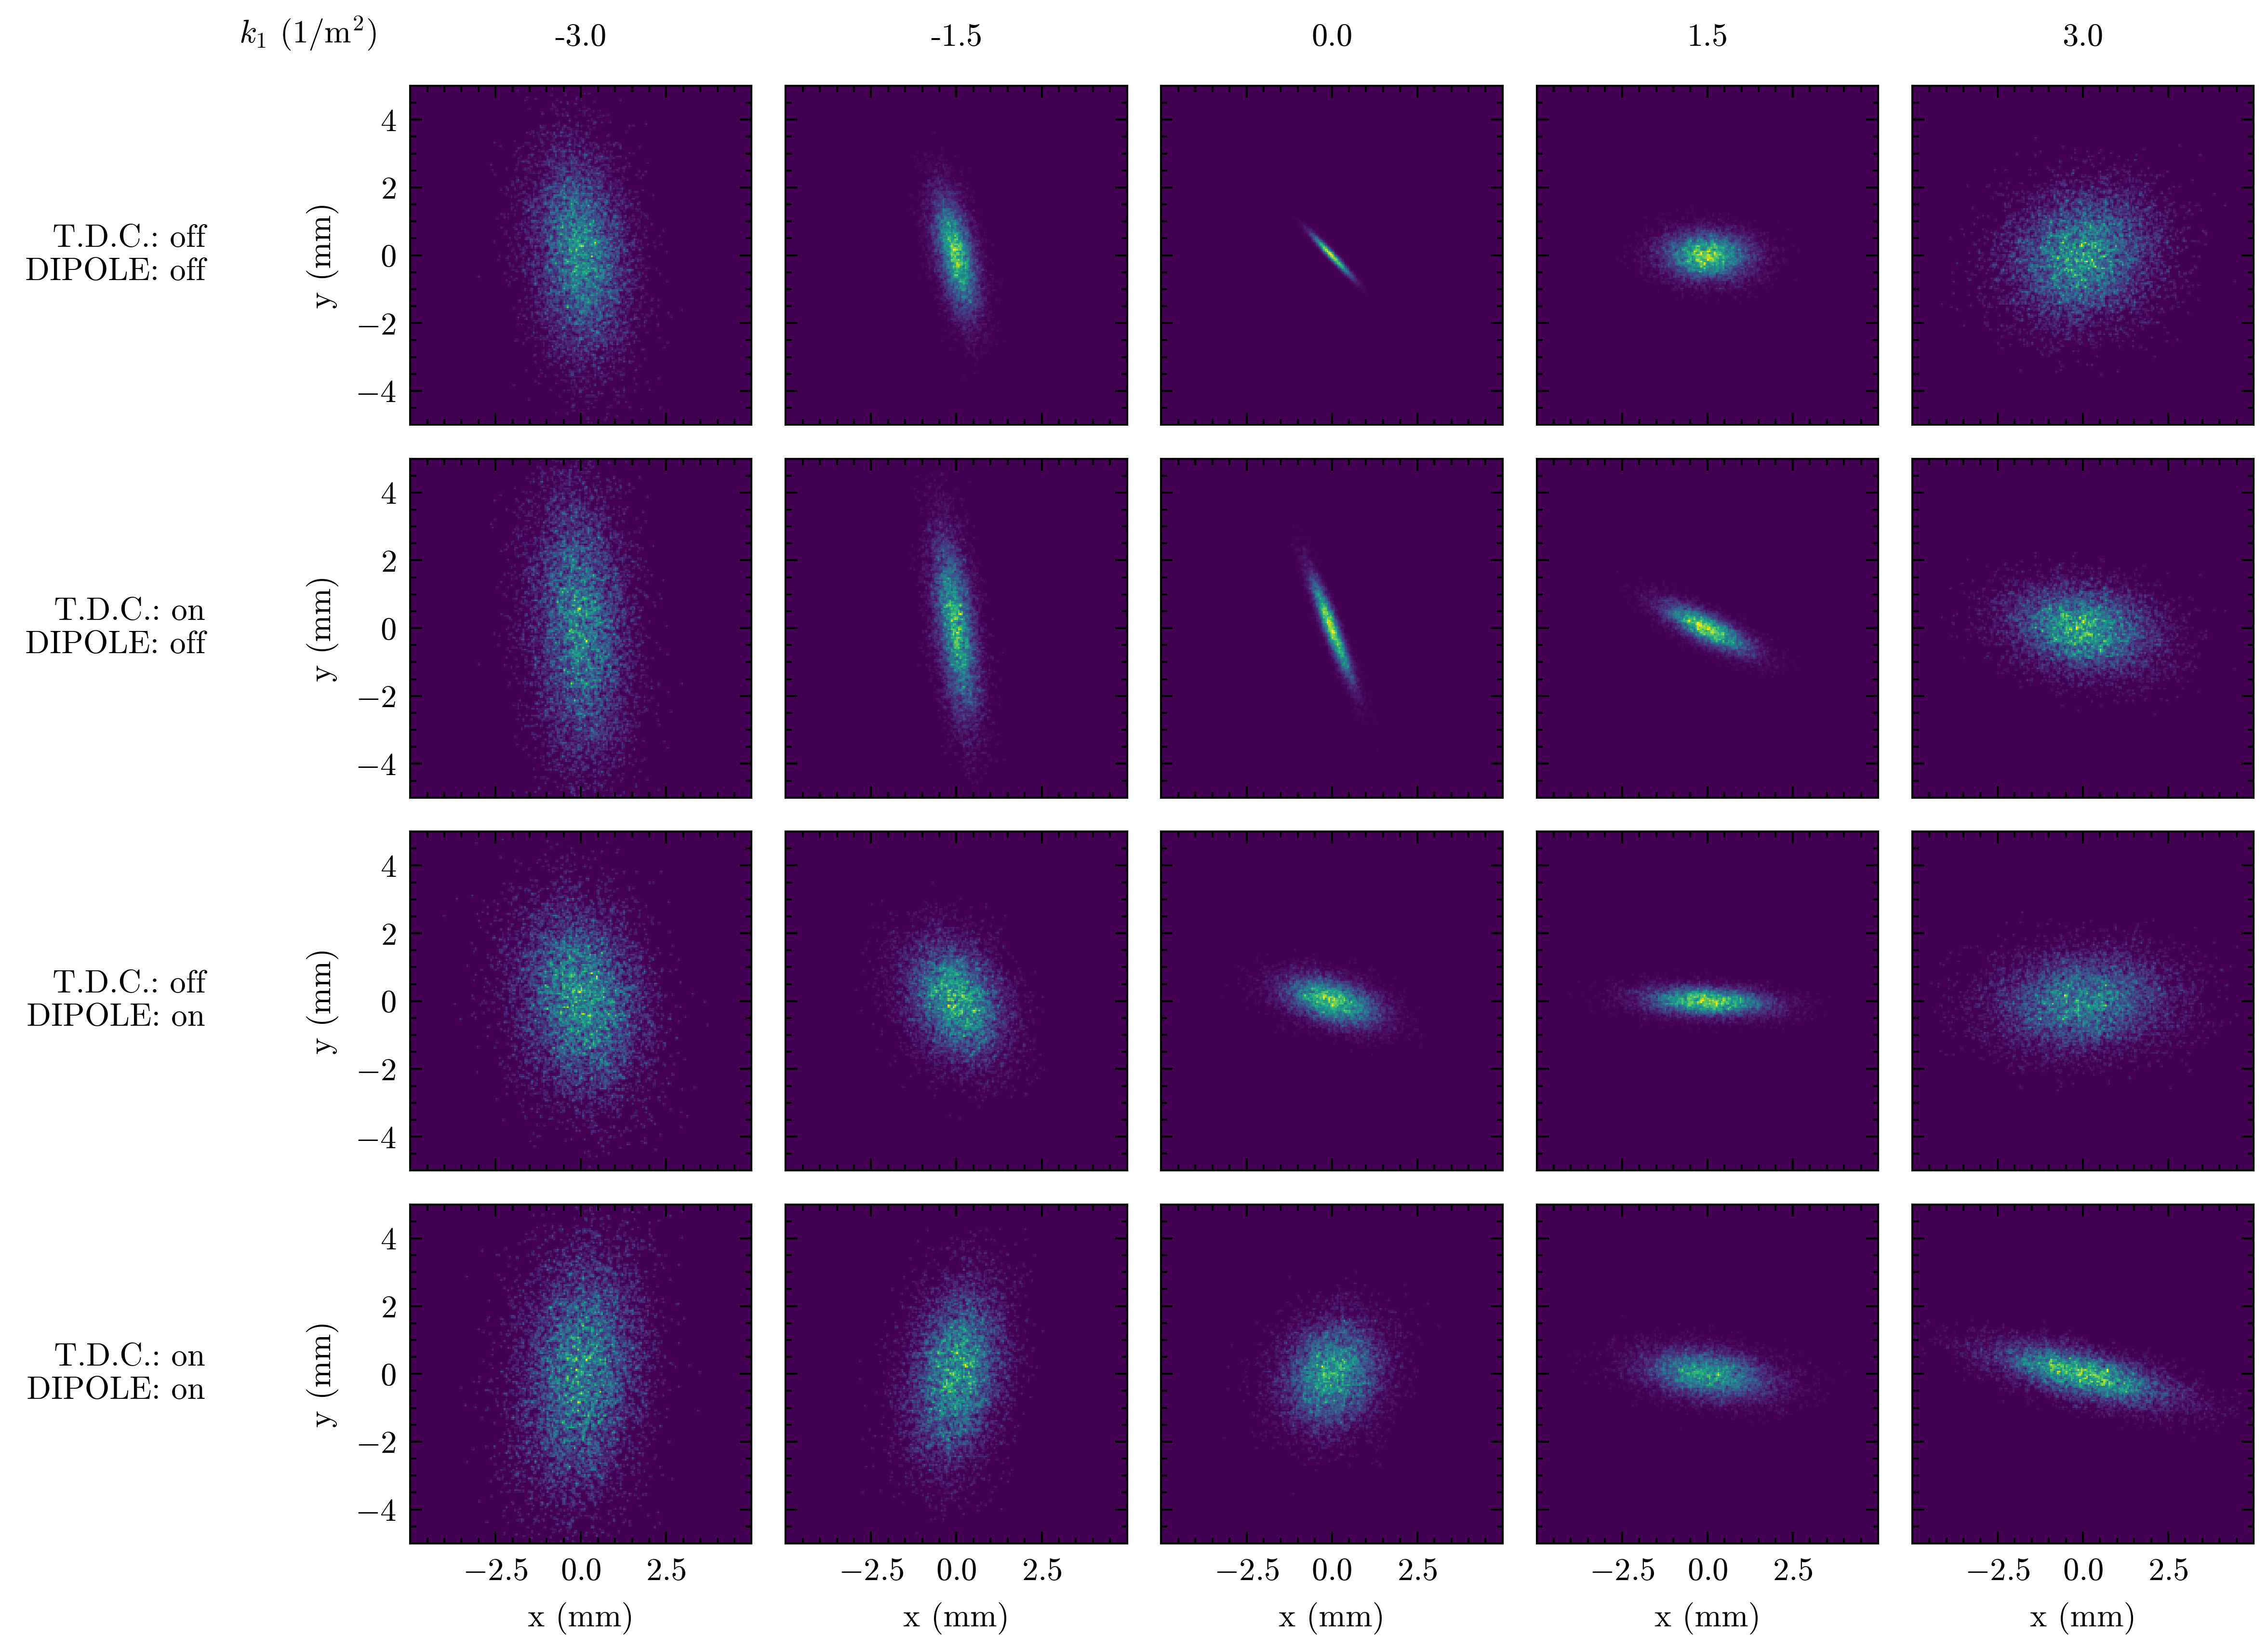

In [37]:
obs_dataset = torch.load("data/gpsr.dset", weights_only=False)
obs_dataset.plot_data(publication_size=True)

### Let's inspect the GPSR dataset.

The dataset is a custom PyTorch `Dataset`:


In [38]:
print(obs_dataset.__class__)
print(obs_dataset.__class__.__bases__[0].__bases__[0])

<class 'gpsr.datasets.SixDReconstructionDataset'>
<class 'torch.utils.data.dataset.Dataset'>


dataset parameters are shaped as:

5 (number of quad strengths) x 2 (TDC on/off) x 2 (Dipole on/off) x 3 (quad, TDC, Dipole values):


In [39]:
print(obs_dataset.six_d_params.shape)

torch.Size([5, 2, 2, 3])


dataset observations are stored in a tuple, each entry corresponds to each screen:


In [40]:
print(len(obs_dataset.observations))
print(obs_dataset.observations[0].shape)
print(obs_dataset.observations[1].shape)

2
torch.Size([10, 200, 200])
torch.Size([10, 200, 200])


dataset also contains a tuple with the Cheetah `Screen` elements for each screen:


In [41]:
print(obs_dataset.screens)

[Screen(resolution=(200, 200), pixel_size=tensor([5.0000e-05, 5.0000e-05]), binning=1, misalignment=tensor([0., 0.]), method='kde', kde_bandwidth=tensor(2.5000e-05), is_active=True, name='unnamed_element_6'), Screen(resolution=(200, 200), pixel_size=tensor([5.0000e-05, 5.0000e-05]), binning=1, misalignment=tensor([0., 0.]), method='kde', kde_bandwidth=tensor(2.5000e-05), is_active=True, name='unnamed_element_6')]


Note that Cheetah `Screen` has kernel density estimation functionality to make histograms differentiable and vectorizable.


### GPSR Diagnostics Lattice

Lattice creation is done using a wrapper class which contains the Cheetah `Segment` for tracking, the cheetah `Screen` elements to observe the beam, and additional GPSR functionalities:


In [42]:
p0c = 43.36e6  # reference momentum in eV/c

l_quad = 0.11
l_tdc = 0.01
f_tdc = 1.3e9
phi_tdc = 0.0
l_bend = 0.3018
theta_on = -20.0 * 3.14 / 180.0
l1 = 0.790702
l2 = 0.631698
l3 = 0.889

gpsr_lattice = GPSR6DLattice(
    l_quad, l_tdc, f_tdc, phi_tdc, l_bend, theta_on, l1, l2, l3, *obs_dataset.screens
)

`lattice` is a Cheetah `Segment`


In [43]:
print(gpsr_lattice.lattice)

Segment(elements=ModuleList(
  (0): Quadrupole(length=tensor(0.1100), k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=5, tracking_method='bmadx', name='SCAN_QUAD')
  (1): Drift(length=tensor(0.7307), tracking_method='cheetah', name='unnamed_element_2976')
  (2): TransverseDeflectingCavity(length=tensor(0.0100), voltage=tensor(0.), phase=tensor(0.), frequency=tensor(1.3000e+09), misalignment=tensor([0., 0.]), tilt=tensor(1.5700), num_steps=1, tracking_method='bmadx', name='SCAN_TDC')
  (3): Drift(length=tensor(0.4758), tracking_method='cheetah', name='unnamed_element_2977')
  (4): Dipole(length=tensor(0.3080), angle=tensor(0.), k1=tensor(0.), dipole_e1=tensor(0.),dipole_e2=tensor(-0.3489),tilt=tensor(0.),gap=tensor(0.),gap_exit=tensor(0.),fringe_integral=tensor(0.),fringe_integral_exit=tensor(0.),fringe_at='both',fringe_type='linear_edge',tracking_method='cheetah', name='SCAN_DIPOLE')
  (5): Drift(length=tensor(0.7284), tracking_method='cheetah', name='DIPOLE_TO

`screens` is a tuple of Cheetah `Screens`


In [44]:
print(gpsr_lattice.screens)

[Screen(resolution=(200, 200), pixel_size=tensor([5.0000e-05, 5.0000e-05]), binning=1, misalignment=tensor([0., 0.]), method='kde', kde_bandwidth=tensor(2.5000e-05), is_active=True, name='unnamed_element_6'), Screen(resolution=(200, 200), pixel_size=tensor([5.0000e-05, 5.0000e-05]), binning=1, misalignment=tensor([0., 0.]), method='kde', kde_bandwidth=tensor(2.5000e-05), is_active=True, name='unnamed_element_6')]


### GPSR Model

contains the beam NN generator and differentiable cheetah tracking lattice:


In [45]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)

Due to the full PyTorch implementation, GPSR can make use of:

- PyTorch `DataLoader`
- PyTorch Lightining, a package that provides a high level interface to train PyTorch models.
- GPU hardware acceleration (if available)


In [46]:
train_loader = torch.utils.data.DataLoader(obs_dataset, batch_size=10)
litgpsr = LitGPSR(gpsr_model)
trainer = L.Trainer(max_epochs=500)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### Training


In [47]:
trainer.fit(model=litgpsr, train_dataloaders=train_loader)


  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode
/opt/homebrew/Caskroom/miniforge/base/envs/malapa-cheetah-tutorial-2025/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/malapa-cheetah-tutorial-2025/lib/python3.13/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


### Results

Predicted and measured screen images for the scan parameters


(<Figure size 4500x3360 with 20 Axes>,
 array([[<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: xlabel='x (mm)', ylabel='y (mm)'>,
         <Axes: xlabel='x (mm)'>, <Axes: xlabel='x (mm)'>,
         <Axes: xlabel='x (mm)'>, <Axes: xlabel='x (mm)'>]], dtype=object))

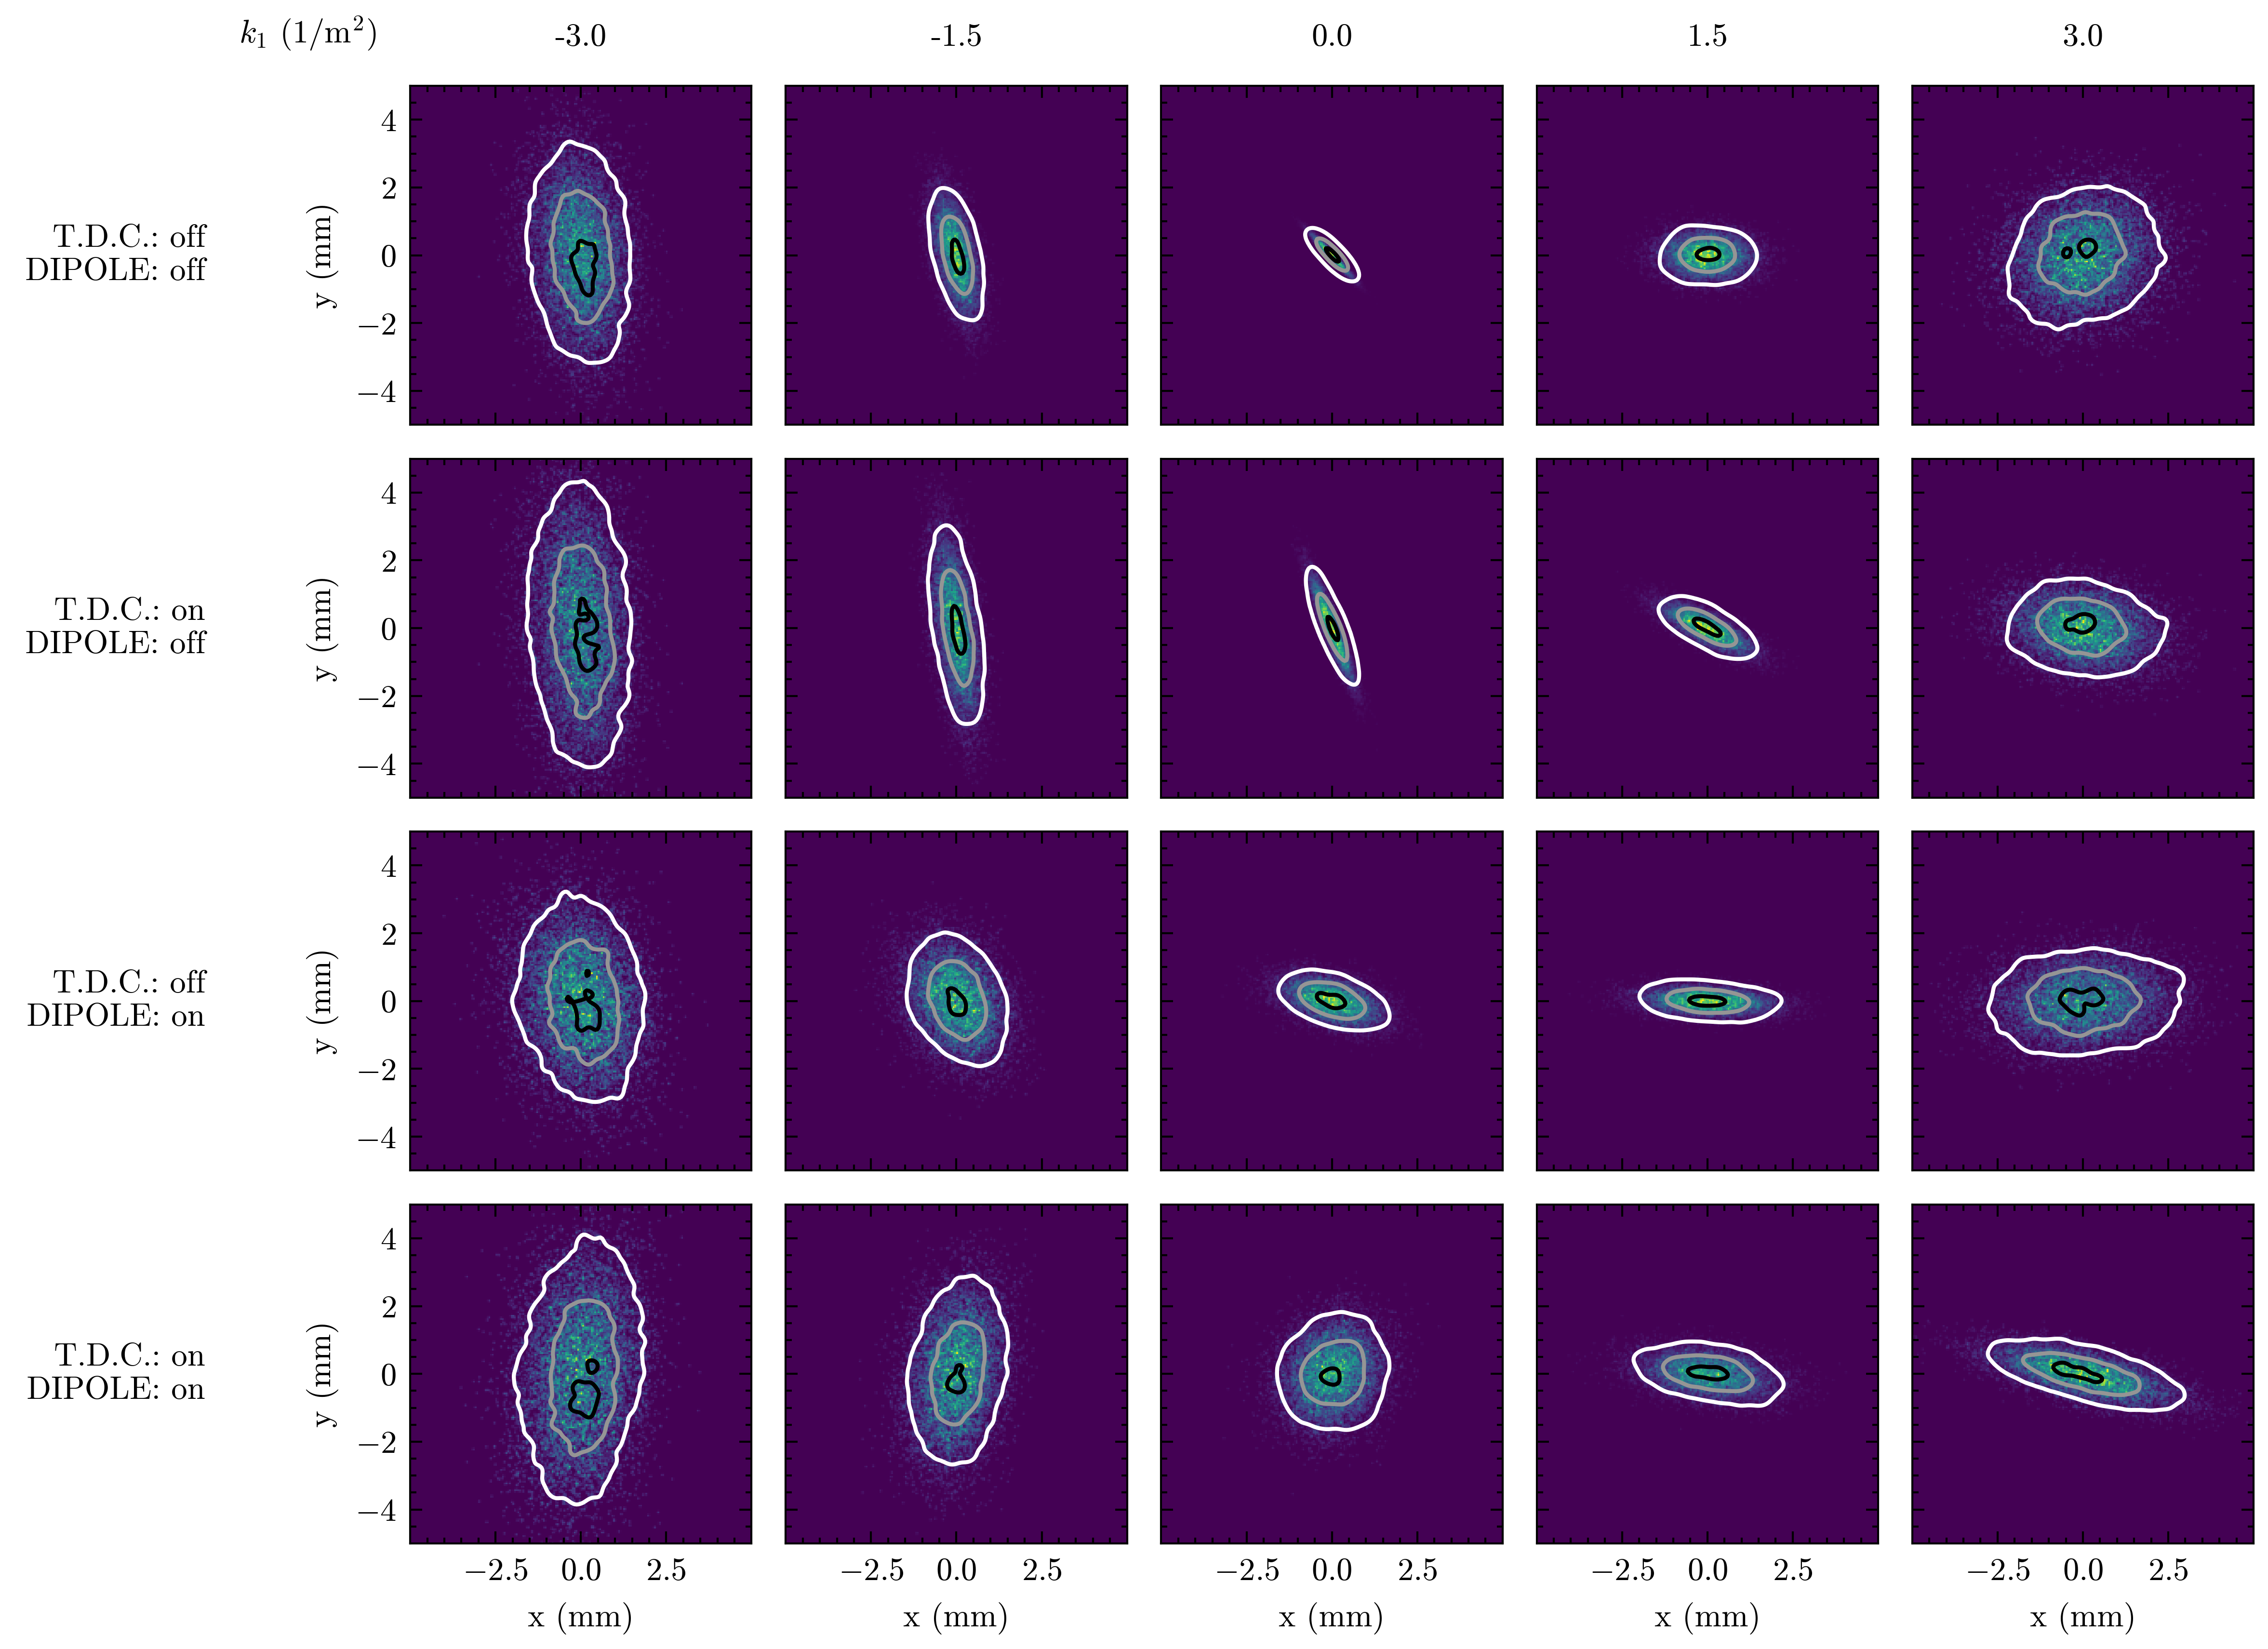

In [48]:
train_params = obs_dataset.six_d_params
pred = tuple([ele.detach() for ele in gpsr_model(train_params)])
pred_dataset = SixDReconstructionDataset(train_params, pred, obs_dataset.screens)
obs_dataset.plot_data(
    publication_size=True,
    overlay_data=pred_dataset,
    overlay_kwargs={"cmap": "Greys", "levels": [0.1, 0.5, 0.9]},
    filter_size=3,
)

### Results

2D projections of the reconstructied 6D phase space distributions:


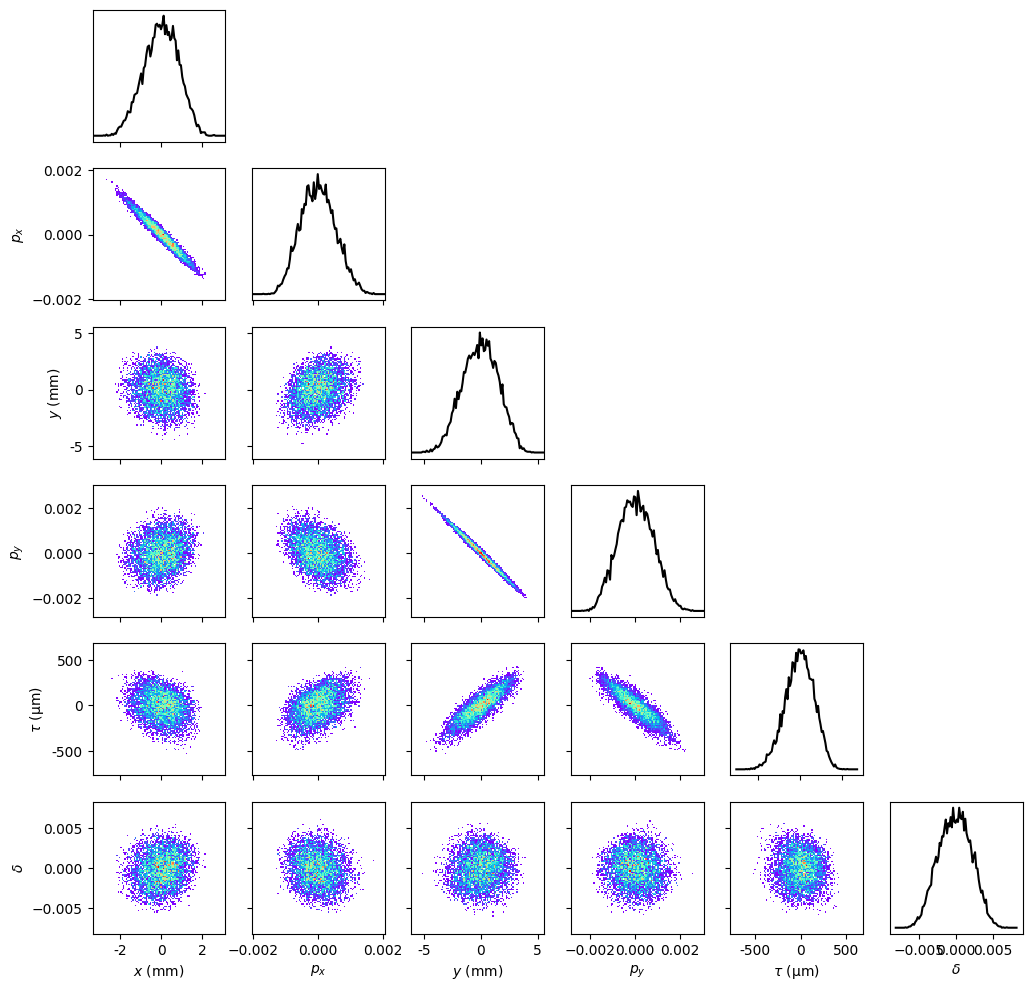

In [50]:
plt.rcdefaults()
reconstructed_beam = litgpsr.gpsr_model.beam_generator()
reconstructed_beam.plot_distribution()
plt.show()